In [ ]:
import pandas as pd
import numpy as np
from optbinning import BinningProcess

## 0. 데이터 불러오기

In [4]:
df = pd.read_csv('./score_data/merged_kpi_dataset_v3.csv')

------

## 1. 전체 데이터로 WOE/IV 계산

In [5]:
df.columns

Index(['SK_ID_CURR', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'TARGET',
       'CC_90PLUS', 'AVG_CARD_USAGE_MONTHS', 'AVG_UTIL_RATIO',
       'AVG_MIN_PAY_RATIO', 'AVG_REPAY_RATIO', 'CREDIT_CARD_HISTORY_YEARS',
       'INST_90PLUS', 'avg_payment_delay', 'pct_underpaid',
       'pct_full_payments', 'LOAN_HISTORY_YEARS', 'IS_LONG_TERM_LOAN',
       'IS_HIGH_INTEREST', 'LOAN_HISTORY_YEARS(prev)', 'NUM_POS_APPLICATIONS',
       'NUM_CASH_APPLICATIONS', 'NUM_REVOLVING_APPLICATIONS', 'REFUSAL_RATE',
       'END_STATUS_SCORE', 'bureau_IS_ACTIVE_ESTIMATED',
       'bureau_IS_CLOSED_ACTUAL', 'bureau_DAYS_CREDIT_ENDDATE',
       'IS_OVERDUE_LONG', 'IS_OVERDUE_SHORT', 'IS_LONG_TERM_ACTIVE',
       'CREDIT_INCREASED', 'DELTA_CREDIT_SUM_IF_INCREASED',
       'DELTA_CREDIT_PCT_IF_INCREASED', 'OVERLAP', 'OVERLAP_YEARS',
       'HAS_HIGH_RISK_DEBT', 'CNT_EARLY_REPAID', 'CNT_REPAID_ON_TIME',
       'CNT_OVERDUE_ENDED', 'CNT_NOT_ENDED', 'CREDIT_AVG_SK_DPD',
       'POS_AVG_SK_DPD', 'NO_CREDIT_HIS

### 1.1 범주형 변수/ 연속형 변수 나누기

In [ ]:
# 범주형 변수
cat_cols = [ 
              'CC_90PLUS',
              'IS_LONG_TERM_LOAN',
              'IS_HIGH_INTEREST',
              'NO_CREDIT_HISTORY_FLAG',
              'IS_OVERDUE_LONG',
              'IS_OVERDUE_SHORT',
              'IS_LONG_TERM_ACTIVE',
              'HAS_HIGH_RISK_DEBT', 
              'INST_90PLUS'
              ]

# 연속형 변수
cont_cols = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AVG_CARD_USAGE_MONTHS', 'AVG_UTIL_RATIO',
       'AVG_MIN_PAY_RATIO', 'AVG_REPAY_RATIO', 'CREDIT_CARD_HISTORY_YEARS',
       'avg_payment_delay', 'pct_underpaid',
       'pct_full_payments', 'LOAN_HISTORY_YEARS', 'LOAN_HISTORY_YEARS(prev)', 'NUM_POS_APPLICATIONS',
       'NUM_CASH_APPLICATIONS', 'NUM_REVOLVING_APPLICATIONS', 'REFUSAL_RATE',
       'END_STATUS_SCORE', 'bureau_IS_ACTIVE_ESTIMATED',
       'bureau_IS_CLOSED_ACTUAL', 'bureau_DAYS_CREDIT_ENDDATE','CREDIT_INCREASED', 'DELTA_CREDIT_SUM_IF_INCREASED',
       'DELTA_CREDIT_PCT_IF_INCREASED', 'OVERLAP', 'OVERLAP_YEARS','CNT_EARLY_REPAID', 'CNT_REPAID_ON_TIME',
       'CNT_OVERDUE_ENDED', 'CNT_NOT_ENDED', 'CREDIT_AVG_SK_DPD',
       'POS_AVG_SK_DPD',
]

In [7]:
len(cat_cols + cont_cols)

41

## 2. WOE 계산

### 2.1 WOE 계산 함수

In [8]:
def calc_woe(df, feature, target='TARGET', bins=10, treat_as_binary=False):
    import numpy as np
    import pandas as pd

    df_tmp = df[[feature, target]].copy()

    if treat_as_binary:
        # 이진 변수 처리
        df_tmp[feature] = df_tmp[feature].fillna('Missing')
        df_tmp['bin'] = df_tmp[feature]
        group = df_tmp.groupby('bin')[target]

    elif pd.api.types.is_numeric_dtype(df_tmp[feature]):
        df_tmp['bin'] = pd.qcut(df_tmp[feature], bins, duplicates='drop')
        if df_tmp[feature].isna().any():
            if 'Missing' not in df_tmp['bin'].cat.categories:
                df_tmp['bin'] = df_tmp['bin'].cat.add_categories('Missing')
            df_tmp.loc[df_tmp[feature].isna(), 'bin'] = 'Missing'
        group = df_tmp.groupby('bin')[target]

    else:
        df_tmp[feature] = df_tmp[feature].fillna('Missing')
        df_tmp['bin'] = df_tmp[feature]
        group = df_tmp.groupby('bin')[target]

    bad = group.sum() + 0.5
    good = group.count() - group.sum() + 0.5
    dist_good = good / good.sum()
    dist_bad = bad / bad.sum()
    woe = np.log(dist_good / dist_bad)
    woe_df = pd.DataFrame({
    'WOE': woe,
    'good': good,
    'bad': bad
})

    return woe_df


In [9]:
woe_results = {}

for feature in cont_cols:
    woe_df = calc_woe(df, feature, target='TARGET', bins=10)
    woe_results[feature] = woe_df

for feature in cat_cols:
    woe_df = calc_woe(df, feature, target='TARGET', treat_as_binary=True)
    woe_results[feature] = woe_df


C:\Users\COTTA\AppData\Local\Temp\ipykernel_14420\664245355.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group = df_tmp.groupby('bin')[target]
C:\Users\COTTA\AppData\Local\Temp\ipykernel_14420\664245355.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group = df_tmp.groupby('bin')[target]
C:\Users\COTTA\AppData\Local\Temp\ipykernel_14420\664245355.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group = d

In [10]:
i = 1
for feature, woe_df in woe_results.items():
    print(f"=== {i}. {feature} ===")
    i += 1
    print(woe_df)
    print()

=== 1. EXT_SOURCE_1 ===
                                    WOE      good      bad
bin                                                       
(0.013600000000000001, 0.213] -0.886262   11058.5   2356.5
(0.213, 0.296]                -0.401036   11858.5   1555.5
(0.296, 0.369]                -0.130559   12194.5   1220.5
(0.369, 0.438]                -0.040958   12288.5   1124.5
(0.438, 0.506]                 0.201873   12517.5    898.5
(0.506, 0.573]                 0.314345   12604.5    808.5
(0.573, 0.64]                  0.483034   12724.5    689.5
(0.64, 0.71]                   0.649330   12825.5    588.5
(0.71, 0.787]                  0.880069   12942.5    471.5
(0.787, 0.963]                 1.200760   13069.5    345.5
Missing                       -0.058551  158607.5  14771.5

=== 2. EXT_SOURCE_2 ===
                             WOE     good     bad
bin                                              
(-0.0009999183, 0.216] -0.939566  25055.5  5631.5
(0.216, 0.34]          -0.447294  

## 3. 신규/기존 고객군 별로 WOE 계산

In [12]:
df2 = pd.read_csv('./score_data/credit_score_flag.csv')

### 3.1 WOE 신규 vs 기존 나눠서 계산

In [41]:
def calc_woe(df, feature, target, bins=10, treat_as_binary=False, return_bins=False, categories=None):

    # 원본 훼손 방지
    df = df.copy()

    if treat_as_binary:  # 범주형 처리
        # 카테고리 순서 지정
        if categories is None:
            categories = df[feature].dropna().unique().tolist()

        # 실제 결측치가 있을 때만 'Missing' 추가
        if df[feature].isna().any() and 'Missing' not in categories:
            categories = categories + ['Missing']

        # 결측치 라벨 부여
        df['bin'] = df[feature].astype(object)
        if df[feature].isna().any():
            df.loc[df[feature].isna(), 'bin'] = 'Missing'

        df['bin'] = pd.Categorical(df['bin'], categories=categories)
        bin_edges = categories

    else:  # 연속형 처리
        if isinstance(bins, int):
            non_missing = df[feature].dropna()
            binned, bin_edges = pd.qcut(non_missing, q=bins, duplicates='drop', retbins=True)
            df['bin'] = None
            df.loc[df[feature].notna(), 'bin'] = binned.astype(object)  # Interval → object 변환
        else:
            non_missing = df[feature].dropna()
            binned = pd.cut(non_missing, bins=bins)
            df['bin'] = None
            df.loc[df[feature].notna(), 'bin'] = binned.astype(object)
            bin_edges = bins if not isinstance(bins, int) else None

        # 실제 결측치 있을 때만 'Missing' 부여
        if df[feature].isna().any():
            df.loc[df[feature].isna(), 'bin'] = 'Missing'

    # Good/Bad 카운트
    grouped = df.groupby('bin', observed=False)[target].agg(['count', 'sum'])
    grouped.columns = ['total', 'bad']
    grouped['good'] = grouped['total'] - grouped['bad']

    # WOE & IV 계산
    eps = 1e-6
    total_good = grouped['good'].sum()
    total_bad = grouped['bad'].sum()
    grouped['woe'] = np.log(((grouped['good'] + eps) / total_good) /
                            ((grouped['bad'] + eps) / total_bad))
    grouped['iv'] = ((grouped['good'] / total_good) - (grouped['bad'] / total_bad)) * grouped['woe']

    if return_bins:
        return grouped.reset_index(), bin_edges
    else:
        return grouped.reset_index()


- `DELTA_CREDIT_PCT_IF_INCREASED` % 단위 변수인데 4만 넘는게 있어서 삭제

In [84]:
# 0) 드랍할 변수 제외
drop_cols = ['DELTA_CREDIT_PCT_IF_INCREASED']
cont_cols = [c for c in cont_cols if c not in drop_cols]
cat_cols  = [c for c in cat_cols  if c not in drop_cols]

### 3.2 연속형/범주형 변수 처리

In [ ]:
# 신규 / 기존 구분
new_client_df = df2[df2['is_new_client'] == '신규']  # 신규 고객
existing_client_df = df2[df2['is_new_client'] == '기존']  # 기존 고객

woe_results_new = {}
woe_results_existing = {}

# -----------------------
# 연속형 변수 처리
# -----------------------
for feature in cont_cols:
    # 1. 전체 데이터 bin 경계 추출
    full_woe_df, bin_edges = calc_woe(df2, feature, target='TARGET', bins=10, return_bins=True)

    # 2. 신규 고객 (bin 경계 고정)
    woe_df_new = calc_woe(new_client_df, feature, target='TARGET', bins=bin_edges)
    woe_results_new[f'new_{feature}'] = woe_df_new

    # 3. 기존 고객 (bin 경계 고정)
    woe_df_existing = calc_woe(existing_client_df, feature, target='TARGET', bins=bin_edges)
    woe_results_existing[f'existing_{feature}'] = woe_df_existing
    
# -----------------------
# 범주형 변수 처리
# -----------------------
for feature in cat_cols:
    # 1. 전체 데이터 카테고리 순서 추출
    categories = df2[feature].dropna().unique().tolist()

    # 2. 신규 고객 (카테고리 순서 고정)
    woe_df_new = calc_woe(new_client_df, feature, target='TARGET',
                          treat_as_binary=True, categories=categories)
    woe_results_new[f'new_{feature}'] = woe_df_new

    # 3. 기존 고객 (카테고리 순서 고정)
    woe_df_existing = calc_woe(existing_client_df, feature, target='TARGET',
                               treat_as_binary=True, categories=categories)
    woe_results_existing[f'existing_{feature}'] = woe_df_existing
    

### 3.3 Missing 비례 패널티 함수

In [90]:
# 1) Missing 비례 패널티 함수 (WOE 컬럼명이 소문자/대문자 모두 대응)
def apply_missing_penalty_variable(woe_df, penalty_max=1.0, woe_max=0.5, only_if_abs_ge=0.1):
    df = woe_df.copy()
    wcol = 'woe' if 'woe' in df.columns else ('WOE' if 'WOE' in df.columns else None)
    if wcol is None:
        raise ValueError("WOE 컬럼을 찾지 못했습니다. ('woe' or 'WOE')")

    mask = (df['bin'] == 'Missing')
    if mask.any():
        w = df.loc[mask, wcol].astype(float)
        # 절댓값이 임계치 이상일 때만 패널티(원하면 0으로)
        if only_if_abs_ge is not None:
            mask_pen = mask & (df[wcol].abs() >= only_if_abs_ge)
        else:
            mask_pen = mask

        # 비례 계수: abs(WOE)/woe_max * penalty_max (상한: penalty_max)
        alpha = (df.loc[mask_pen, wcol].abs() / woe_max) * penalty_max
        alpha = alpha.clip(upper=penalty_max)
        df.loc[mask_pen, wcol] = df.loc[mask_pen, wcol] * (1 - alpha)
    return df

# 2) dict 전체에 패널티 적용 (기본: '신규'에만 적용, 기존도 원하면 목록에 추가)
def penalize_missing_on_dicts(woe_new_dict, woe_existing_dict,
                              groups_to_penalize=('신규',),
                              penalty_max=0.5, woe_max=0.5, only_if_abs_ge=0.1):
    new_p, ex_p = {}, {}
    for k, v in woe_new_dict.items():
        feat = k.replace('new_', '')
        if '신규' in groups_to_penalize:
            new_p[k] = apply_missing_penalty_variable(v, penalty_max, woe_max, only_if_abs_ge)
        else:
            new_p[k] = v.copy()
    for k, v in woe_existing_dict.items():
        feat = k.replace('existing_', '')
        if '기존' in groups_to_penalize:
            ex_p[k] = apply_missing_penalty_variable(v, penalty_max, woe_max, only_if_abs_ge)
        else:
            ex_p[k] = v.copy()
    return new_p, ex_p

# 3) 실제 적용: 신규만 패널티(예: 최대 50%까지, woe_max=0.5 기준)
woe_results_new_pen, woe_results_existing_pen = penalize_missing_on_dicts(
    woe_results_new, woe_results_existing,
    groups_to_penalize=('신규',),   # ('신규','기존')로 바꾸면 둘 다 적용
    penalty_max=1.0,                # 최대 50%까지 깎기 -> 100%
    woe_max=0.5,                    # WOE 0.5를 상한으로 정규화
    only_if_abs_ge=0.1              # |WOE|>=0.1인 Missing만 패널티
)

### 3.4 그래프 출력

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
import matplotlib.font_manager as fm

plt.rc('font', family='Malgun Gothic')  # Windows
plt.rc('axes', unicode_minus=False)     # 마이너스 깨짐 방지

#### Line Graph

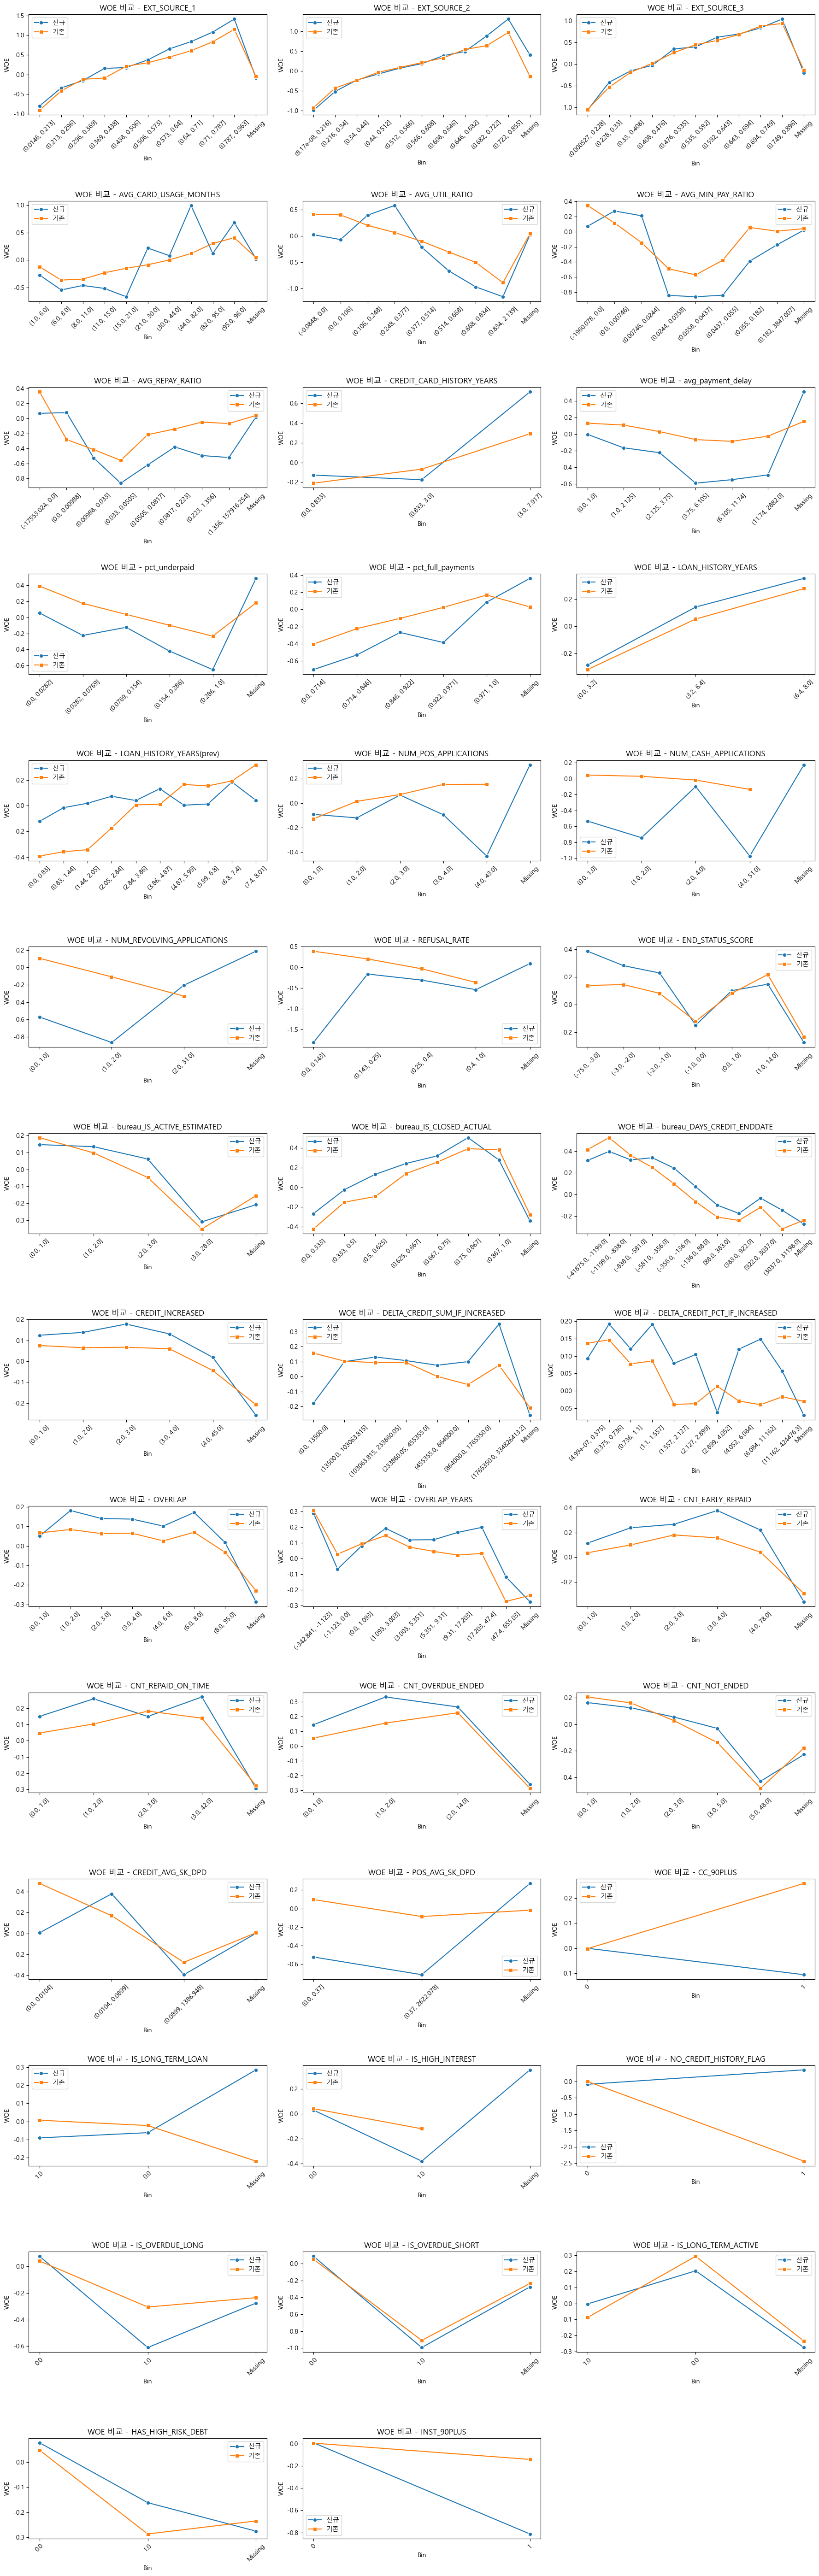

In [45]:
def plot_woe_overlay(woe_new_dict, woe_existing_dict, features):
    n_features = len(features)
    n_cols = 3  # 한 행에 3개 feature
    n_rows = math.ceil(n_features / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows), squeeze=False)

    for idx, feature in enumerate(features):
        row = idx // n_cols
        col = idx % n_cols

        woe_new_df = woe_new_dict[f'new_{feature}'].copy()
        woe_existing_df = woe_existing_dict[f'existing_{feature}'].copy()

        # bin을 문자열로 변환
        woe_new_df['bin'] = woe_new_df['bin'].astype(str)
        woe_existing_df['bin'] = woe_existing_df['bin'].astype(str)

        ax = axes[row][col]

        # 신규
        sns.lineplot(x='bin', y='woe', data=woe_new_df, marker='o', label='신규', ax=ax)
        # 기존
        sns.lineplot(x='bin', y='woe', data=woe_existing_df, marker='s', label='기존', ax=ax)

        ax.set_title(f'WOE 비교 - {feature}')
        ax.set_xlabel('Bin')
        ax.set_ylabel('WOE')
        ax.tick_params(axis='x', rotation=45)
        ax.legend()

    # 남는 subplot 숨기기
    total_plots = n_rows * n_cols
    for i in range(n_features, total_plots):
        r = i // n_cols
        c = i % n_cols
        axes[r][c].axis('off')

    plt.tight_layout()
    plt.show()

# 실행
all_features = cont_cols + cat_cols
plot_woe_overlay(woe_results_new, woe_results_existing, all_features)

### 3.5 IV 비율로 가중치 산정

In [91]:
iv_summary = []

for feature in all_features:
    iv_new = woe_results_new[f'new_{feature}']['iv'].sum()
    iv_existing = woe_results_existing[f'existing_{feature}']['iv'].sum()
    iv_avg = (iv_new + iv_existing) / 2
    iv_summary.append({'feature': feature, 'IV_new': iv_new, 'IV_existing': iv_existing, 'IV_avg': iv_avg})

iv_df = pd.DataFrame(iv_summary)
iv_df['weight'] = iv_df['IV_avg'] / iv_df['IV_avg'].sum()  # IV 비율로 가중치 산정

In [92]:
print(iv_df)

                          feature    IV_new  IV_existing    IV_avg    weight
0                    EXT_SOURCE_1  0.172229     0.147088  0.159659  0.067013
1                    EXT_SOURCE_2  0.390167     0.285589  0.337878  0.141816
2                    EXT_SOURCE_3  0.313507     0.333308  0.323407  0.135742
3           AVG_CARD_USAGE_MONTHS  0.014774     0.021961  0.018368  0.007709
4                  AVG_UTIL_RATIO  0.025074     0.076118  0.050596  0.021236
5               AVG_MIN_PAY_RATIO  0.018150     0.045801  0.031976  0.013421
6                 AVG_REPAY_RATIO  0.013613     0.039544  0.026579  0.011156
7       CREDIT_CARD_HISTORY_YEARS  0.098986     0.042577  0.070781  0.029709
8               avg_payment_delay  0.212564     0.005998  0.109281  0.045868
9                   pct_underpaid  0.241284     0.031192  0.136238  0.057183
10              pct_full_payments  0.104483     0.041828  0.073155  0.030705
11             LOAN_HISTORY_YEARS  0.072474     0.059652  0.066063  0.027728

-------

#### Bar Graph - 패널티 부여 전/후

In [ ]:
def plot_woe_bar_overlay(woe_new_dict, woe_existing_dict, features):
    n_features = len(features)
    n_cols = 3  # 한 행에 3개 feature
    n_rows = math.ceil(n_features / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows), squeeze=False)

    for idx, feature in enumerate(features):
        row = idx // n_cols
        col = idx % n_cols

        woe_new_df = woe_new_dict[f'new_{feature}'].copy()
        woe_existing_df = woe_existing_dict[f'existing_{feature}'].copy()

        # bin을 문자열로 변환
        woe_new_df['bin'] = woe_new_df['bin'].astype(str)
        woe_existing_df['bin'] = woe_existing_df['bin'].astype(str)

        # 그룹 라벨 & 샘플 수 컬럼
        woe_new_df['group'] = '신규'
        woe_existing_df['group'] = '기존'
        woe_new_df['count'] = woe_new_df['total']
        woe_existing_df['count'] = woe_existing_df['total']

        merged_df = pd.concat([woe_new_df, woe_existing_df], ignore_index=True)

        # seaborn이 임의 정렬하지 않도록 순서 고정
        bin_order = list(merged_df['bin'].unique())
        hue_order = ['신규', '기존']

        ax = axes[row][col]

        # 막대그래프
        sns.barplot(
            x='bin', y='woe', hue='group', data=merged_df,
            order=bin_order, hue_order=hue_order, ax=ax
        )

        # --- 막대 위에 샘플 수(n=) 라벨 추가 ---
        # seaborn의 막대 순서에 맞춰 count를 재정렬
        idx_order = pd.MultiIndex.from_product([bin_order, hue_order], names=['bin','group'])
        counts_in_order = (merged_df.groupby(['bin','group'], sort=False)['count']
                           .sum().reindex(idx_order).fillna(0).astype(int).values)

        for patch, n in zip(ax.patches, counts_in_order):
            height = patch.get_height()
            ax.text(
                patch.get_x() + patch.get_width()/2,
                height + (0.02 if height >= 0 else -0.06),  # 음수일 때도 보기 좋게
                f'{n}', ha='center', va='bottom', fontsize=8, rotation=0
            )
        # ---------------------------------------

        ax.set_title(f'WOE 비교 - {feature}')
        ax.set_xlabel('Bin')
        ax.set_ylabel('WOE')
        ax.tick_params(axis='x', rotation=45)
        ax.legend()

    # 남는 subplot 숨기기
    total_plots = n_rows * n_cols
    for i in range(n_features, total_plots):
        r = i // n_cols
        c = i % n_cols
        axes[r][c].axis('off')

    plt.tight_layout()
    plt.show()

# 실행
all_features = cont_cols + cat_cols
# plot_woe_bar_overlay(woe_results_new, woe_results_existing, all_features)

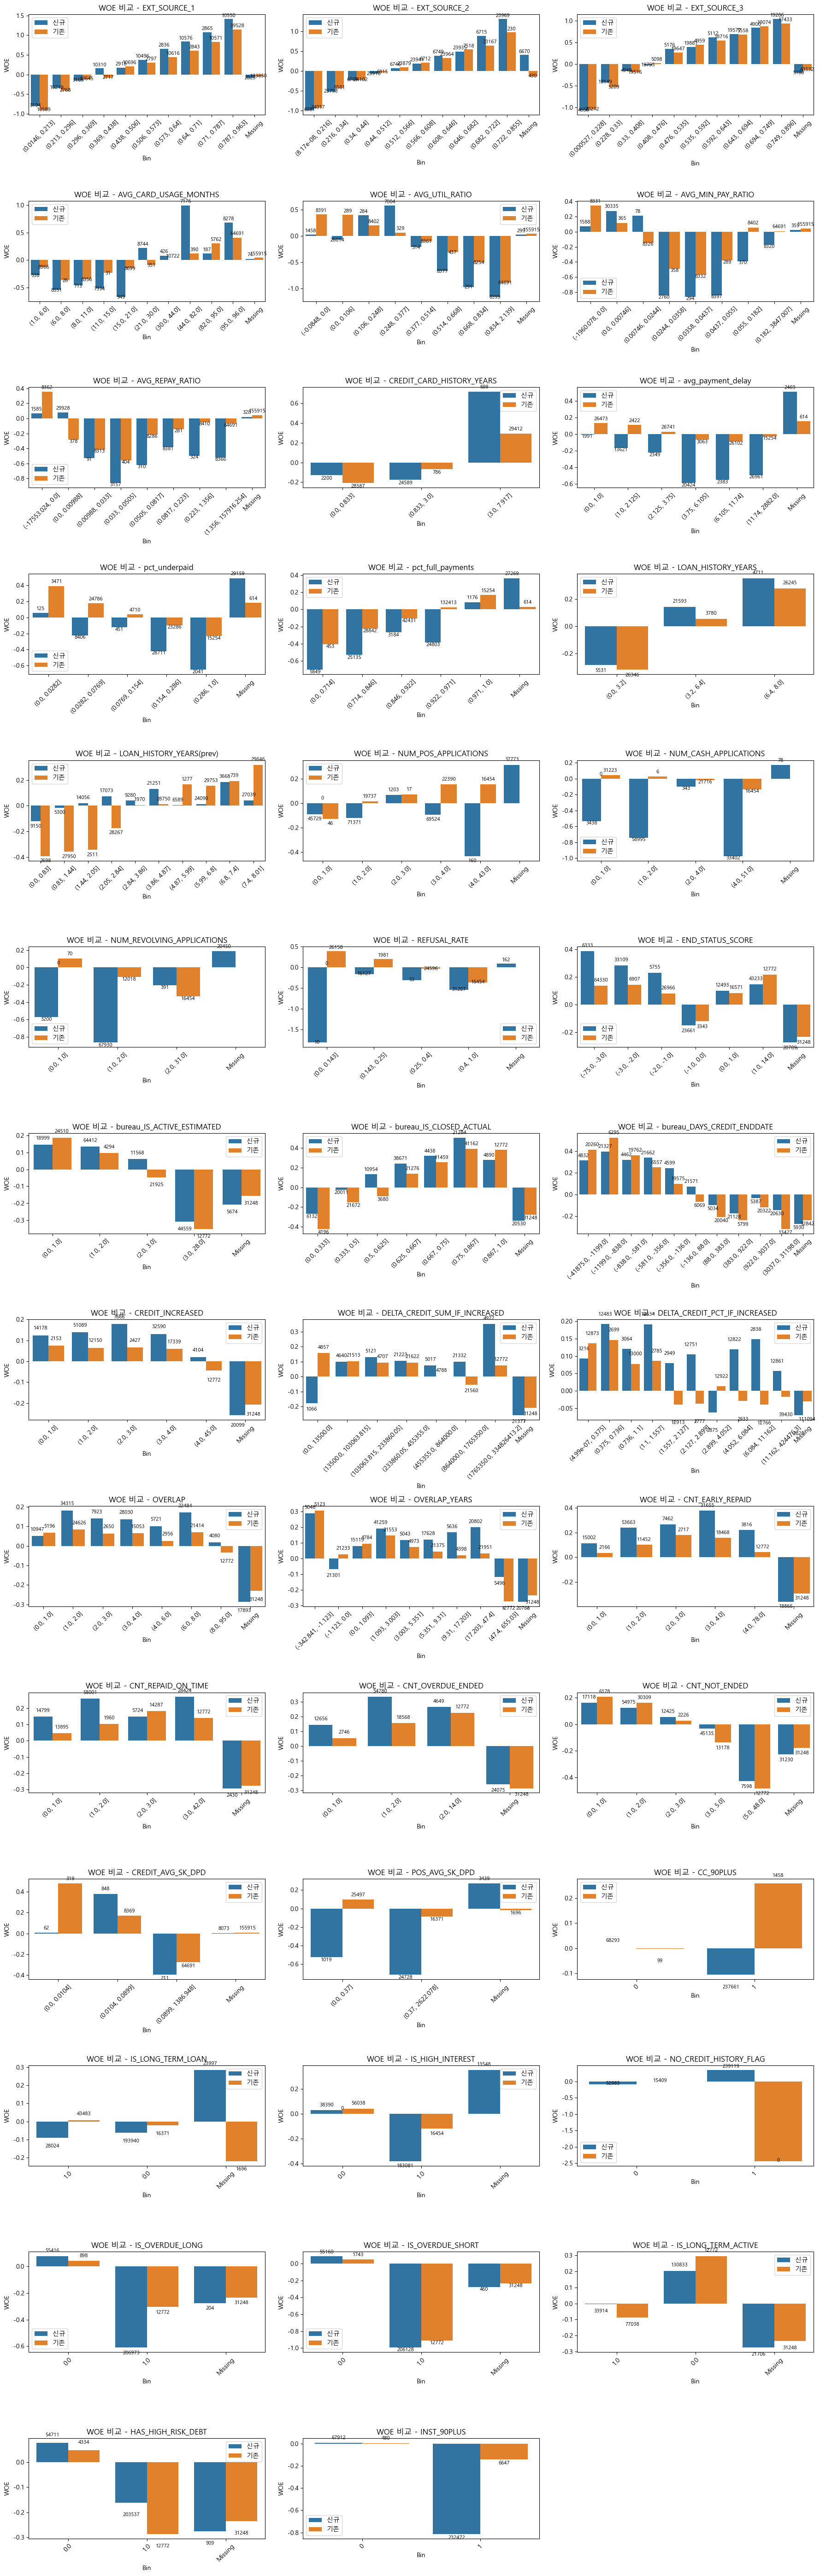

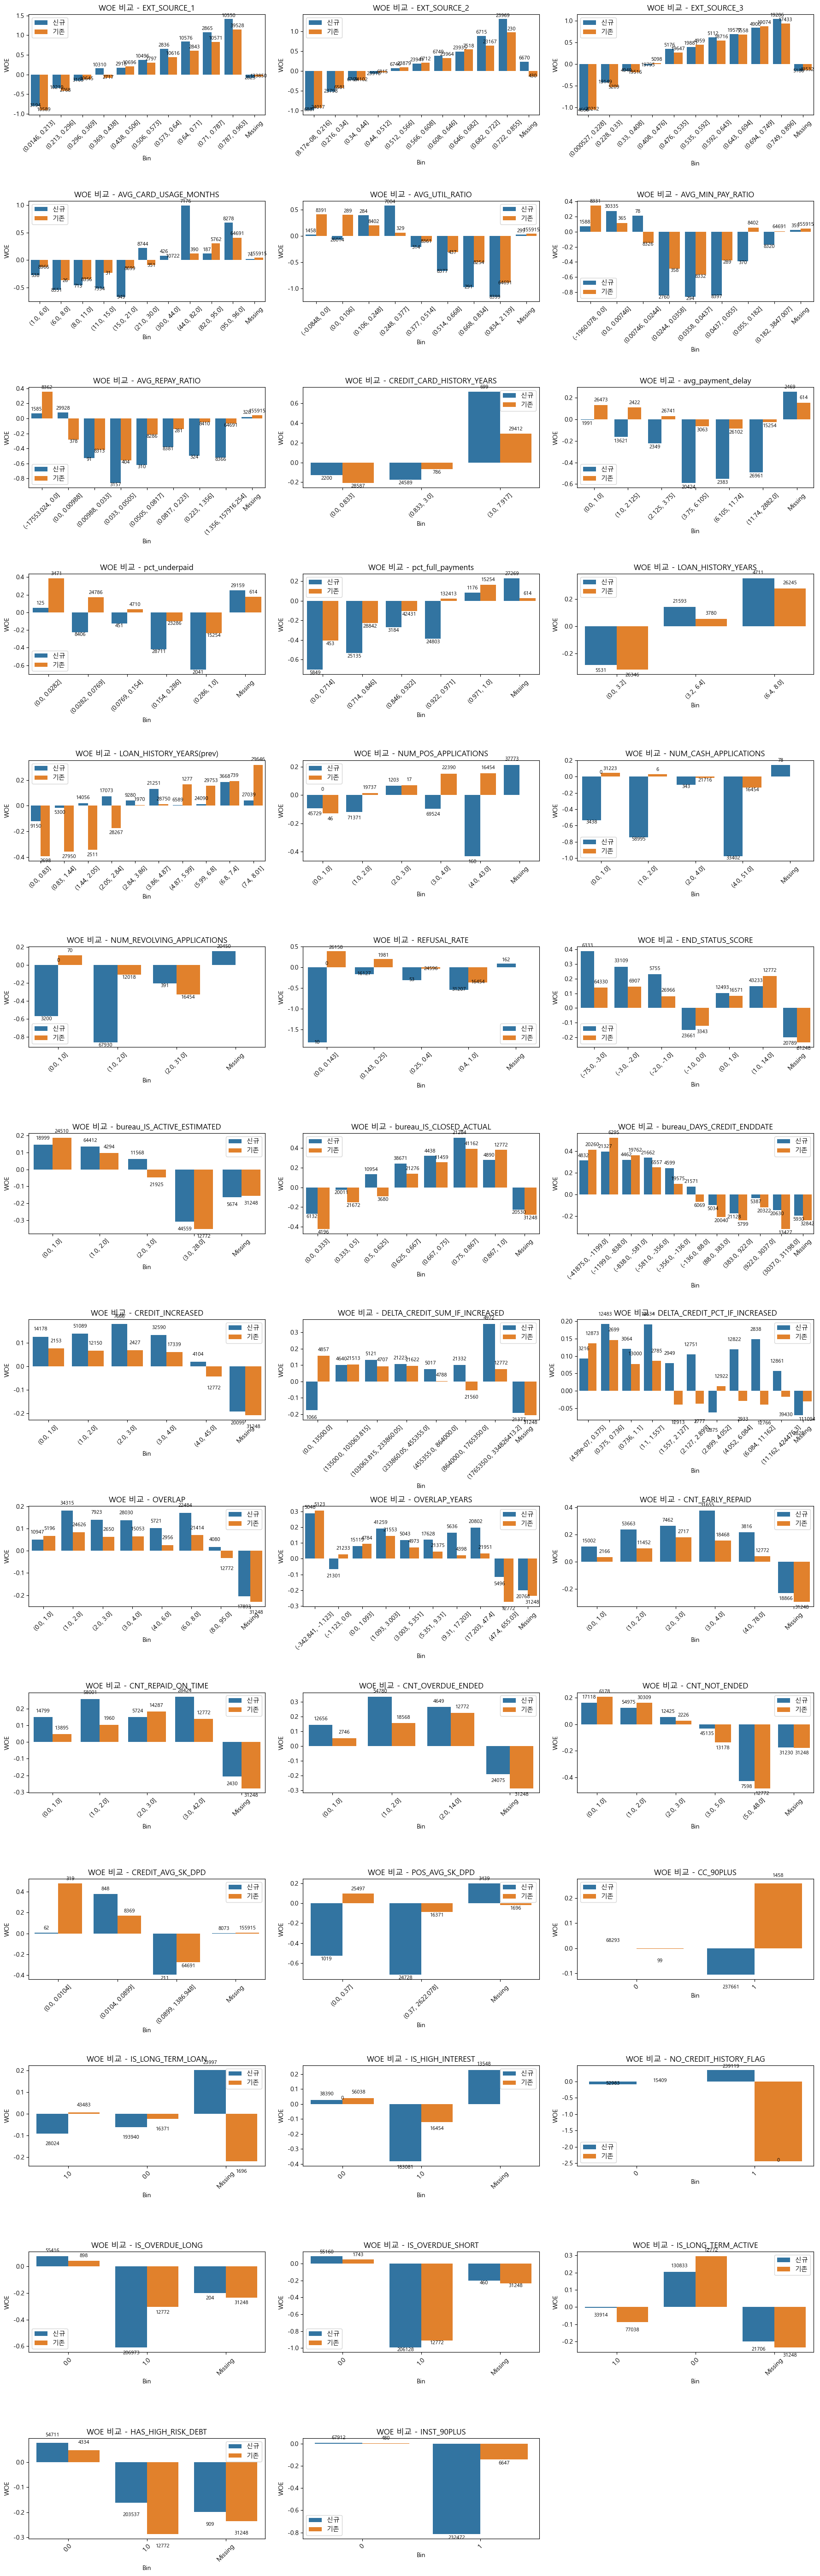

In [86]:
# 기존 그래프
plot_woe_bar_overlay(woe_results_new, woe_results_existing, all_features)

# 패널티 적용 후 그래프
plot_woe_bar_overlay(woe_results_new_pen, woe_results_existing_pen, all_features)

- 얼마나 패널티 적용되었는지

In [94]:
def compare_missing_change(woe_before, woe_after):
    for feat in woe_before.keys():
        df_b = woe_before[feat]
        df_a = woe_after[feat]
        missing_b = df_b[df_b['bin'] == 'Missing']['woe'].values
        missing_a = df_a[df_a['bin'] == 'Missing']['woe'].values
        if missing_b.size > 0:
            print(f"{feat} | Before: {missing_b[0]:.4f} → After: {missing_a[0]:.4f}")

compare_missing_change(woe_results_new, woe_results_new_pen)


new_EXT_SOURCE_1 | Before: -0.0913 → After: -0.0913
new_EXT_SOURCE_2 | Before: 0.4074 → After: 0.0755
new_EXT_SOURCE_3 | Before: -0.2071 → After: -0.1213
new_AVG_CARD_USAGE_MONTHS | Before: 0.0211 → After: 0.0211
new_AVG_UTIL_RATIO | Before: 0.0211 → After: 0.0211
new_AVG_MIN_PAY_RATIO | Before: 0.0211 → After: 0.0211
new_AVG_REPAY_RATIO | Before: 0.0211 → After: 0.0211
new_avg_payment_delay | Before: 0.5116 → After: 0.0000
new_pct_underpaid | Before: 0.4834 → After: 0.0160
new_pct_full_payments | Before: 0.3608 → After: 0.1005
new_NUM_POS_APPLICATIONS | Before: 0.3130 → After: 0.1171
new_NUM_CASH_APPLICATIONS | Before: 0.1754 → After: 0.1139
new_NUM_REVOLVING_APPLICATIONS | Before: 0.1871 → After: 0.1171
new_REFUSAL_RATE | Before: 0.0924 → After: 0.0924
new_END_STATUS_SCORE | Before: -0.2754 → After: -0.1237
new_bureau_IS_ACTIVE_ESTIMATED | Before: -0.2090 → After: -0.1216
new_bureau_IS_CLOSED_ACTUAL | Before: -0.3417 → After: -0.1082
new_bureau_DAYS_CREDIT_ENDDATE | Before: -0.2735 →

In [95]:
iv_summary = []

for feature in all_features:
    iv_new = woe_results_new_pen[f'new_{feature}']['iv'].sum()
    iv_existing = woe_results_existing_pen[f'existing_{feature}']['iv'].sum()
    iv_avg = (iv_new + iv_existing) / 2
    iv_summary.append({
        'feature': feature,
        'IV_new': iv_new,
        'IV_existing': iv_existing,
        'IV_avg': iv_avg
    })

iv_df = pd.DataFrame(iv_summary)
iv_df['weight'] = iv_df['IV_avg'] / iv_df['IV_avg'].sum()


In [97]:
print(iv_df)

                          feature    IV_new  IV_existing    IV_avg    weight
0                    EXT_SOURCE_1  0.172229     0.147088  0.159659  0.067192
1                    EXT_SOURCE_2  0.390167     0.285589  0.337878  0.142194
2                    EXT_SOURCE_3  0.313507     0.333308  0.323407  0.136104
3           AVG_CARD_USAGE_MONTHS  0.014774     0.021961  0.018368  0.007730
4                  AVG_UTIL_RATIO  0.025074     0.076118  0.050596  0.021293
5               AVG_MIN_PAY_RATIO  0.018150     0.045801  0.031976  0.013457
6                 AVG_REPAY_RATIO  0.013613     0.039544  0.026579  0.011186
7       CREDIT_CARD_HISTORY_YEARS  0.098986     0.042577  0.070781  0.029788
8               avg_payment_delay  0.212564     0.005998  0.109281  0.045990
9                   pct_underpaid  0.241284     0.031192  0.136238  0.057335
10              pct_full_payments  0.104483     0.041828  0.073155  0.030787
11             LOAN_HISTORY_YEARS  0.072474     0.059652  0.066063  0.027802

#### 고객별 bin 매핑

In [100]:
# 연속형
for feature in cont_cols:
    full_woe_df, bin_edges = calc_woe(df2, feature, target='TARGET', bins=10, return_bins=True)

    # 1) 우선 binning
    binned = pd.cut(df2[feature], bins=bin_edges, include_lowest=True)

    # 2) 카테고리 순서 정의(+ 'Missing'을 맨 뒤에)
    cats = list(binned.cat.categories) + ['Missing']
    dtype = pd.api.types.CategoricalDtype(categories=cats, ordered=True)

    # 3) 임시로 object로 바꿔서 결측치 채우기
    binned_obj = binned.astype(object)
    binned_obj[df2[feature].isna()] = 'Missing'

    # 4) 다시 원하는 Categorical로 캐스팅
    df2[f'{feature}_bin'] = pd.Series(binned_obj, index=df2.index).astype(dtype)

# 범주형
for feature in cat_cols:
    # WOE 결과에서 쓰는 카테고리 순서 가져오기
    base_cats = list(woe_results_new_pen[f'new_{feature}']['bin'].cat.categories)
    if 'Missing' not in base_cats:
        base_cats = base_cats + ['Missing']
    dtype = pd.api.types.CategoricalDtype(categories=base_cats, ordered=True)

    # 결측은 'Missing'으로 채우고, 정의한 Categorical로 변환
    ser = df2[feature].where(df2[feature].notna(), 'Missing').astype(object)
    df2[f'{feature}_bin'] = ser.astype(dtype)


#### 점수 계산 함수

In [101]:
def get_feature_score(row, feature, woe_new_dict, woe_existing_dict, weight):
    if row['is_new_client'] == '신규':
        woe_df = woe_new_dict[f'new_{feature}']
    else:
        woe_df = woe_existing_dict[f'existing_{feature}']

    bin_val = row[f'{feature}_bin']
    match = woe_df[woe_df['bin'] == bin_val]
    if not match.empty:
        woe_val = match['woe'].values[0]
        return woe_val * weight
    return 0

df2['raw_score'] = 0
for idx, row in df2.iterrows():
    total_score = 0
    for _, r in iv_df.iterrows():
        total_score += get_feature_score(row, r['feature'], woe_results_new_pen, woe_results_existing_pen, r['weight'])
    df2.at[idx, 'raw_score'] = total_score


C:\Users\COTTA\AppData\Local\Temp\ipykernel_14420\2247458971.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.030710227480935312' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df2.at[idx, 'raw_score'] = total_score


#### 점수 스케일링

In [102]:
target_mean = 650
target_std = 100
mean_raw = df2['raw_score'].mean()
std_raw = df2['raw_score'].std()

df2['final_score'] = ((df2['raw_score'] - mean_raw) / std_raw) * target_std + target_mean

In [103]:
scores = df2['final_score'].astype(float).dropna()

summary = scores.describe(percentiles=[.01,.05,.10,.25,.50,.75,.90,.95,.99])
print(summary)


count    307511.000000
mean        650.000000
std         100.000000
min         351.272686
1%          453.951766
5%          494.633303
10%         520.538445
25%         574.601517
50%         646.687936
75%         720.708804
90%         784.136701
95%         819.876905
99%         883.539764
max        1035.426849
Name: final_score, dtype: float64


In [104]:
labels = ['<550','550–599','600–649','650–699','700–749','750+']
bins   = [-np.inf, 549, 599, 649, 699, 749, np.inf]

df2['score_band'] = pd.cut(
    df2['final_score'], bins=bins, labels=labels,
    right=True, include_lowest=True, ordered=True
)

band_df = (df2['score_band'].value_counts()
           .reindex(labels)
           .rename('count')
           .to_frame())
band_df['pct'] = (band_df['count'] / band_df['count'].sum()).round(4)
band_df['cum_pct'] = band_df['pct'].cumsum().round(4)
print(band_df)

# 저장(원하시면)
band_df.to_csv('final_score_band_distribution.csv', encoding='utf-8-sig', index=True)


            count     pct  cum_pct
score_band                        
<550        53423  0.1737   0.1737
550–599     49672  0.1615   0.3352
600–649     53295  0.1733   0.5085
650–699     52892  0.1720   0.6805
700–749     45346  0.1475   0.8280
750+        52883  0.1720   1.0000


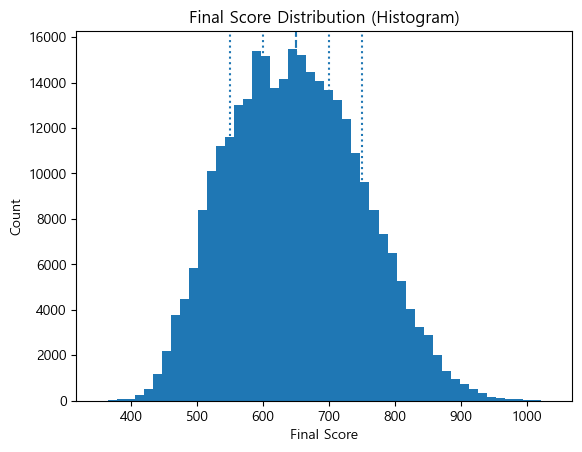

In [105]:
plt.figure()
plt.hist(scores, bins=50)
plt.title('Final Score Distribution (Histogram)')
plt.xlabel('Final Score'); plt.ylabel('Count')

# 평균선 + 밴드 경계선
plt.axvline(scores.mean(), linestyle='--')
for t in [550,600,650,700,750]:
    plt.axvline(t, linestyle=':')

plt.show()


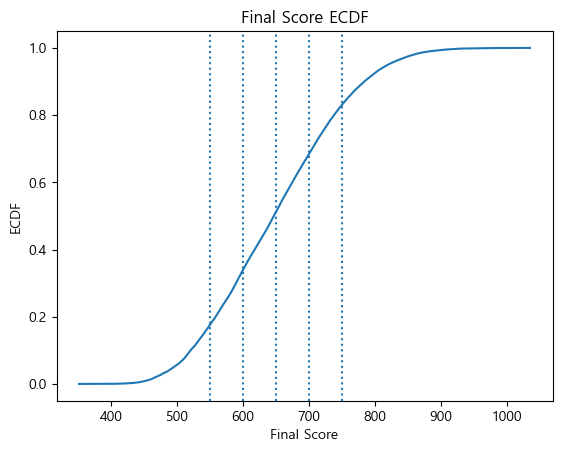

In [106]:
sorted_scores = np.sort(scores.values)
y = np.arange(1, len(sorted_scores)+1) / len(sorted_scores)

plt.figure()
plt.plot(sorted_scores, y)
plt.title('Final Score ECDF')
plt.xlabel('Final Score'); plt.ylabel('ECDF')

for t in [550,600,650,700,750]:
    plt.axvline(t, linestyle=':')

plt.show()


---

In [128]:
# ========================
# 파라미터(원하시는 값으로 변경)
# ========================
target_mean = 650        # 끌어올릴 평균
target_sigma = 100       # 방법B에서 사용할 표준편차
q_lower, q_upper = 0.01, 0.99  # 방법C에서 사용할 백분위 구간

# 원본 점수(연속)
raw = pd.to_numeric(df2['raw_score'], errors='coerce')

# 공통 보조치
mean_raw = float(raw.mean())
std_raw  = float(raw.std(ddof=1))

# ========================
# 방법 A) min-max(0~900) → 평균 오프셋
#   - 순위 보존(클리핑 발생 시 끝점 동률)
#   - 이상치에 민감
# ========================
raw_min = float(raw.min())
raw_max = float(raw.max())
scaleA  = 900.0 / max(raw_max - raw_min, 1e-12)
baseA   = ((raw - raw_min) * scaleA).clip(0, 900)
deltaA  = target_mean - float(baseA.mean())
score_minmax_offset = (baseA + deltaA).clip(0, 900)

# ========================
# 방법 B) z-스케일 → (μ=target_mean, σ=target_sigma) → 0/900 클립
#   - 평균을 거의 정확히 맞춤(클리핑 적으면 정확)
#   - σ가 크면 양끝 클리핑 증가
# ========================
z = (raw - mean_raw) / max(std_raw, 1e-12)
score_z_mu_sigma = (z * target_sigma + target_mean).clip(0, 900)

# ========================
# 방법 C) 퍼센타일 앵커(1~99%)를 0~900으로 선형 매핑 → 평균 오프셋
#   - 이상치에 둔감(꼬리 압축)
#   - 내부 구간에서는 순위 보존, 꼬리는 클리핑으로 동률
# ========================
q_low, q_high = raw.quantile([q_lower, q_upper])
scaleC  = 900.0 / max(float(q_high - q_low), 1e-12)
baseC   = ((raw - q_low) * scaleC).clip(0, 900)
deltaC  = target_mean - float(baseC.mean())
score_pct_offset = (baseC + deltaC).clip(0, 900)

# ========================
# df2에 저장(정수 점수 원하면 round/astype 추가)
# ========================
df2['score_minmax_offset'] = score_minmax_offset.round().astype(int)
df2['score_z_mu_sigma']    = score_z_mu_sigma.round().astype(int)
df2['score_pct_offset']    = score_pct_offset.round().astype(int)

# ========================
# 비교 요약(평균/표준편차/끝단 클리핑비율/원점수 상관)
# ========================
def clip_share(s):
    s = pd.to_numeric(s, errors='coerce')
    return (s.eq(0).mean(), s.eq(900).mean())

summ_rows = []
for name, s in [
    ('minmax_offset', df2['score_minmax_offset']),
    ('z_mu_sigma',    df2['score_z_mu_sigma']),
    ('pct_offset',    df2['score_pct_offset']),
]:
    s = pd.to_numeric(s, errors='coerce')
    c0, c900 = clip_share(s)
    summ_rows.append({
        'score_name': name,
        'mean': float(s.mean()),
        'std': float(s.std(ddof=1)),
        'min': int(s.min()),
        'p10': float(s.quantile(0.10)),
        'p50': float(s.quantile(0.50)),
        'p90': float(s.quantile(0.90)),
        'max': int(s.max()),
        'clip@0': round(c0, 4),
        'clip@900': round(c900, 4),
        'corr_with_raw': float(pd.to_numeric(df2['raw_score'], errors='coerce').corr(s))
    })

compare_summary = pd.DataFrame(summ_rows)
display(compare_summary)


score_name        mean         std  min    p10    p50    p90  max  \
0  minmax_offset  648.494064  128.159881  257  480.0  646.0  826.0  900   
1     z_mu_sigma  649.828224   99.524737  351  521.0  647.0  784.0  900   
2     pct_offset  637.505793  185.945600  240  379.0  643.0  900.0  900   

   clip@0  clip@900  corr_with_raw  
0     0.0    0.0330       0.996698  
1     0.0    0.0064       0.999577  
2     0.0    0.1277       0.979730

In [130]:
# 서로 간 상관
scores_df = df2[['score_minmax_offset','score_z_mu_sigma','score_pct_offset']].astype(float)
display("Pairwise correlation among three scores:")
display(scores_df.corr())

# (선택) TARGET이 있으면 상관(참고용)
if 'TARGET' in df2.columns:
    print("\nCorrelation with TARGET (Pearson, 참고용):")
    print(scores_df.apply(lambda s: s.corr(df2['TARGET'])))

'Pairwise correlation among three scores:'

score_minmax_offset  score_z_mu_sigma  score_pct_offset
score_minmax_offset             1.000000          0.998054          0.989050
score_z_mu_sigma                0.998054          1.000000          0.981959
score_pct_offset                0.989050          0.981959          1.000000


Correlation with TARGET (Pearson, 참고용):
score_minmax_offset   -0.181649
score_z_mu_sigma      -0.180292
score_pct_offset      -0.184098
dtype: float64


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

y = df2['TARGET'].astype(int)
cols = ['score_minmax_offset','score_z_mu_sigma','score_pct_offset']

for c in cols:
    s_good = pd.to_numeric(df2[c], errors='coerce')
    s_risk = -s_good  # 방향 교정: 클수록 '부실'로 해석
    auc = roc_auc_score(y, s_risk)
    fpr, tpr, _ = roc_curve(y, s_risk)
    ks = np.max(np.abs(tpr - fpr))
    print(c, {'AUC': round(auc,4), 'KS': round(ks,4)})

score_minmax_offset {'AUC': 0.6931, 'KS': 0.293}
score_z_mu_sigma {'AUC': 0.6931, 'KS': 0.2931}
score_pct_offset {'AUC': 0.6928, 'KS': 0.2931}


In [133]:
# 최종 표시 점수(0~900, 높을수록 우량) 선택
df2['score_final_display'] = df2['score_pct_offset']  # 또는 score_z_mu_sigma

# 평가/의사결정용 위험 점수(높을수록 위험)
df2['score_risk'] = -pd.to_numeric(df2['score_final_display'], errors='coerce')

In [ ]:
# s: 위험 점수(클수록 위험)
s = pd.to_numeric(df2['score_risk'], errors='coerce')

# 5분위로 자르되, 동점 많으면 자동으로 구간 수 줄임
qcat = pd.qcut(s, q=5, labels=False, duplicates='drop')

# 실제 생성된 구간 수에 맞춰 라벨 준비 (낮은 위험이 A)
labels_full = ['A(매우우량)','B(우량)','C(보통)','D(주의)','E(위험)']
uniq_bins = int(qcat.max()) + 1
labels = labels_full[:uniq_bins]

# 라벨 매핑 + 순서형 카테고리로 저장
df2['grade'] = qcat.map({i: labels[i] for i in range(uniq_bins)})
df2['grade'] = pd.Categorical(df2['grade'], categories=labels, ordered=True)

In [139]:
band_sum = df2.groupby('grade').agg(
    cnt=('TARGET','size'),
    bad_rate=('TARGET','mean'),
    avg_disp_score=('score_final_display','mean')
)
band_sum['bad_rate'] = band_sum['bad_rate'].round(4)
band_sum

C:\Users\COTTA\AppData\Local\Temp\ipykernel_14420\581580163.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  band_sum = df2.groupby('grade').agg(


cnt  bad_rate  avg_disp_score
grade                                   
A(매우우량)  61615    0.0222      887.485158
B(우량)    61798    0.0441      765.543982
C(보통)    61128    0.0675      642.723286
D(주의)    61557    0.1108      521.927271
E(위험)    61413    0.1593      368.519581

In [142]:
# grade = A~E, TARGET=1이 연체
tmp = df2.assign(bad=df2['TARGET'].astype(int))
tot_bad = tmp['bad'].sum()
cap = (tmp.groupby('grade')['bad'].sum()
         .reindex(['A(매우우량)','B(우량)','C(보통)','D(주의)','E(위험)']))
cap_pct = (cap / tot_bad).round(4)
lift20 = (cap_pct['E(위험)'] / 0.2).round(2)          # Top 20% lift
lift40 = ((cap_pct['D(주의)'] + cap_pct['E(위험)']) / 0.4).round(2)
print(cap_pct, {'Lift@20%': lift20, 'Lift@40%': lift40})

grade
A(매우우량)    0.0550
B(우량)      0.1098
C(보통)      0.1662
D(주의)      0.2748
E(위험)      0.3942
Name: bad, dtype: float64 {'Lift@20%': 1.97, 'Lift@40%': 1.67}


C:\Users\COTTA\AppData\Local\Temp\ipykernel_14420\3417287006.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cap = (tmp.groupby('grade')['bad'].sum()


In [149]:
cols = [
    'SK_ID_CURR',
    'score_z_mu_sigma',
    'score_pct_offset',
    'score_risk',
    'grade'
]

display(df2[cols])

SK_ID_CURR  score_z_mu_sigma  score_pct_offset  score_risk  grade
0           100002               558               458        -458  E(위험)
1           100003               627               601        -601  C(보통)
2           100004               720               798        -798  B(우량)
3           100006               581               507        -507  D(주의)
4           100007               533               406        -406  E(위험)
...            ...               ...               ...         ...    ...
307506      456251               606               559        -559  D(주의)
307507      456252               535               409        -409  E(위험)
307508      456253               647               644        -644  C(보통)
307509      456254               710               777        -777  B(우량)
307510      456255               699               754        -754  B(우량)

[307511 rows x 5 columns]

In [150]:
df2.drop(columns=['score_minmax_offset'], errors='ignore', inplace=True)

In [158]:
display(df2['score_z_mu_sigma'].describe())
display(df2['score_pct_offset'].describe())

count    307511.000000
mean        649.828224
std          99.524737
min         351.000000
25%         575.000000
50%         647.000000
75%         721.000000
max         900.000000
Name: score_z_mu_sigma, dtype: float64

count    307511.000000
mean        637.505793
std         185.945600
min         240.000000
25%         492.000000
50%         643.000000
75%         798.000000
max         900.000000
Name: score_pct_offset, dtype: float64

In [162]:
display(df2['score_pct_offset'].value_counts())
display(df2['score_z_mu_sigma'].value_counts())

score_pct_offset
900    39276
240     3140
529      688
663      663
702      641
       ...  
244       77
247       73
245       73
242       64
246       63
Name: count, Length: 661, dtype: int64

score_z_mu_sigma
900    1967
656    1341
592    1339
606    1235
675    1226
       ... 
381       1
367       1
353       1
372       1
358       1
Name: count, Length: 534, dtype: int64

In [156]:
# 1) 방향 확인: 위험점수↑ → 부실↑ (양의 상관이면 OK)
print('corr(score_risk, TARGET)=', df2['score_risk'].corr(df2['TARGET']))

# 2) 평가 지표는 항상 risk 기준(AUC>0.5가 나와야 정상)
from sklearn.metrics import roc_auc_score
print('AUC(risk)=', roc_auc_score(df2['TARGET'].astype(int), df2['score_risk']))

corr(score_risk, TARGET)= 0.18409831591598383
AUC(risk)= 0.6927676998150936


In [157]:
chk = (-pd.to_numeric(df2['score_pct_offset'], errors='coerce')).astype(float)
print('all equal?:', (df2['score_risk'].astype(float).round(6) == chk.round(6)).all())

all equal?: True


### 스케일링 방법간 그래프 분포 차이

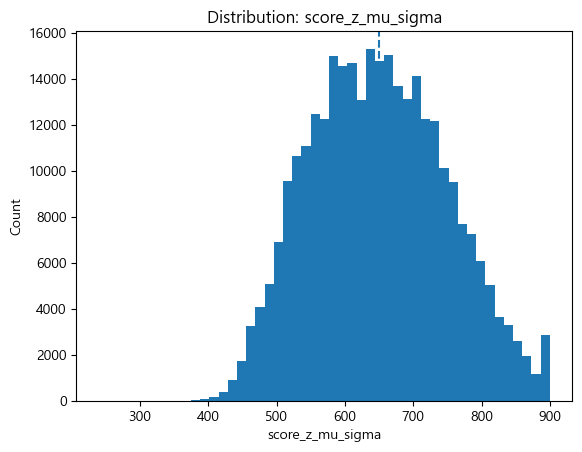

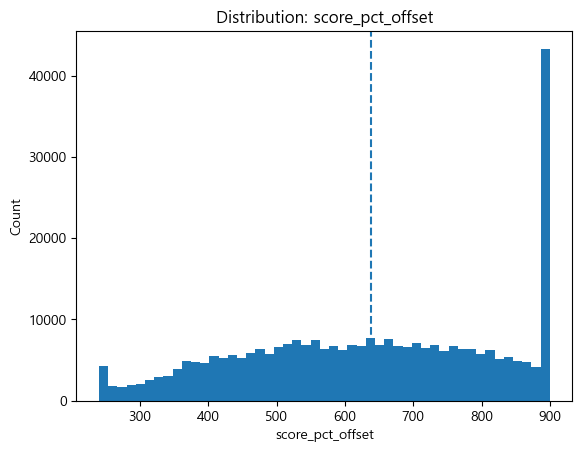

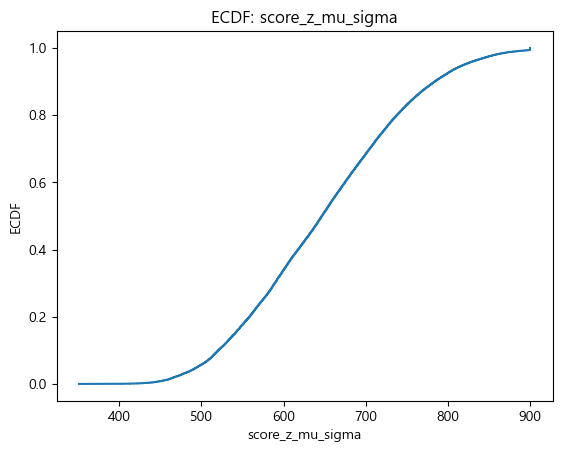

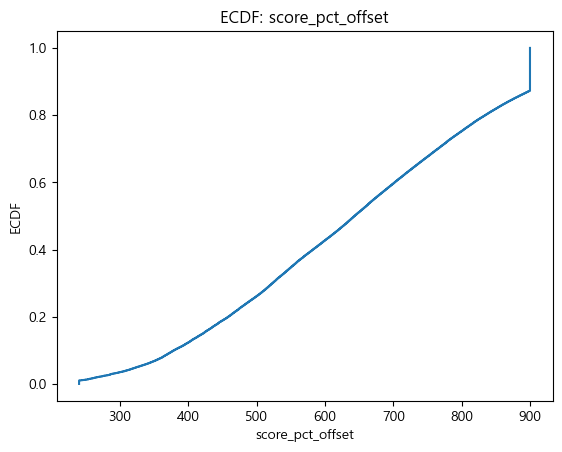

pct_offset == 0 비율: 0.0  / == 900 비율: 0.12772226034190648


In [159]:
z = pd.to_numeric(df2['score_z_mu_sigma'], errors='coerce').dropna()
p = pd.to_numeric(df2['score_pct_offset'], errors='coerce').dropna()

# 공통 bin (두 점수의 전체 범위 기준)
low  = float(np.min([z.min(), p.min()]))
high = float(np.max([z.max(), p.max()]))
bins = np.linspace(low, high, 50)

# ---- 1) 히스토그램 ----
plt.figure()
plt.hist(z, bins=bins)
plt.title("Distribution: score_z_mu_sigma")
plt.xlabel("score_z_mu_sigma"); plt.ylabel("Count")
plt.axvline(z.mean(), linestyle="--")
plt.show()

plt.figure()
plt.hist(p, bins=bins)
plt.title("Distribution: score_pct_offset")
plt.xlabel("score_pct_offset"); plt.ylabel("Count")
plt.axvline(p.mean(), linestyle="--")
plt.show()

# ---- 2) ECDF(누적분포) ----
def plot_ecdf(series, title):
    x = np.sort(series.values)
    y = np.arange(1, len(x)+1) / len(x)
    plt.figure()
    plt.plot(x, y)
    plt.title(f"ECDF: {title}")
    plt.xlabel(title); plt.ylabel("ECDF")
    plt.show()

plot_ecdf(z, "score_z_mu_sigma")
plot_ecdf(p, "score_pct_offset")

# (선택) 포화 비율 체크
print("pct_offset == 0 비율:", (p==0).mean(), " / == 900 비율:", (p==900).mean())

In [ ]:
# 표시/보고용 점수(높을수록 우량)
df2['score_display'] = pd.to_numeric(df2['score_z_mu_sigma'], errors='coerce').round().astype('Int64')

# 평가/컷오프용 위험점수(높을수록 위험)
df2['score_risk'] = -df2['score_display'].astype('float')

# 안 쓰는 컬럼 정리(선택)
# df2.drop(columns=['score_pct_offset'], errors='ignore', inplace=True)

In [164]:
# qcut: 균등개수 5구간(동점 많으면 자동 축소)
qcat = pd.qcut(df2['score_risk'], q=5, labels=False, duplicates='drop')
labels = ['A(매우우량)','B(우량)','C(보통)','D(주의)','E(위험)'][:int(qcat.max())+1]
df2['grade'] = qcat.map({i: labels[i] for i in range(len(labels))}).astype('category')
df2['grade'] = df2['grade'].cat.set_categories(labels, ordered=True)

In [ ]:
y = df2['TARGET'].astype(int)
auc = roc_auc_score(y, df2['score_risk'])
fpr, tpr, _ = roc_curve(y, df2['score_risk'])
ks = float(np.max(np.abs(tpr - fpr)))
print({'AUC': round(auc,4), 'KS': round(ks,4)})

# 등급별 연체율 단조성 확인(상승해야 정상)
print(df2.groupby('grade')['TARGET'].mean().round(4))

{'AUC': 0.6931, 'KS': 0.2931}
grade
A(매우우량)    0.0223
B(우량)      0.0442
C(보통)      0.0676
D(주의)      0.1108
E(위험)      0.1593
Name: TARGET, dtype: float64


C:\Users\COTTA\AppData\Local\Temp\ipykernel_14420\2542441443.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df2.groupby('grade')['TARGET'].mean().round(4))


In [ ]:
import json

mean_raw = float(df2['raw_score'].mean())
std_raw  = float(df2['raw_score'].std(ddof=1))
cfg = {
  "scale_method": "z_mu_sigma",
  "scale_params": {"mean_raw": mean_raw, "std_raw": std_raw, "mu": 650.0, "sigma": 100.0, "clip": [0, 900]},
  "grading": {}  # 운영에서 qcut로 매번 나눌 거면 비워둬도 됨. 고정 경계를 쓰면 여기에 분위수 경계 저장
}
open("scaler_grader.json","w").write(json.dumps(cfg, ensure_ascii=False, indent=2))

# 결과물 저장
df2[['SK_ID_CURR','score_display','score_risk','grade']].to_csv('scored_z_only.csv', index=False, encoding='utf-8-sig')


In [167]:
# z를 ±3σ 윈저라이즈 후 650±100 변환
z = ((df2['raw_score'] - mean_raw) / max(std_raw, 1e-12)).clip(-3, 3)
df2['score_display'] = (z*100 + 650).round().astype('Int64')
df2['score_risk'] = -df2['score_display'].astype(float)

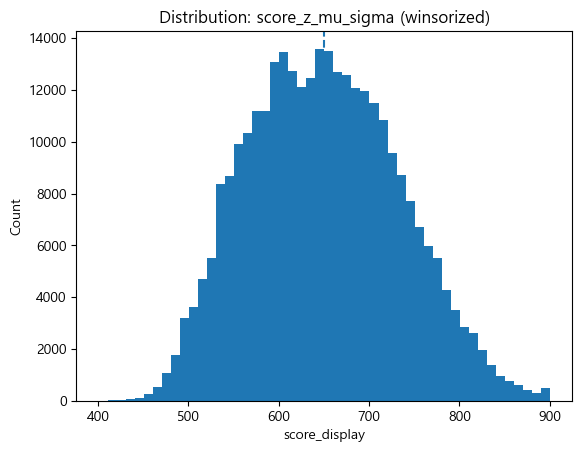

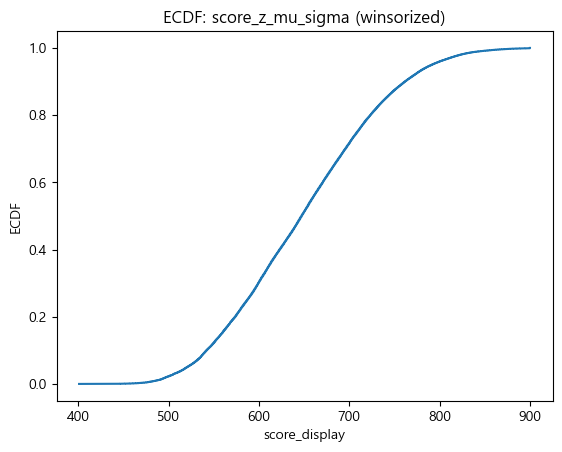

min/max: 401 900
==900 비율: 0.001043865097508707  / ==0 비율: 0.0
count    307511.00
mean        649.98
std          83.27
min         401.00
1%          487.00
5%          521.00
10%         542.00
25%         587.00
50%         647.00
75%         709.00
90%         762.00
95%         792.00
99%         845.00
max         900.00
Name: score_display, dtype: float64
           cnt  bad_rate   avg_score
grade                               
A(매우우량)  61972    0.0223  770.058413
B(우량)    61394    0.0442  695.709336
C(보통)    61332    0.0676  646.944482
D(주의)    61363    0.1108  598.895507
E(위험)    61450    0.1593  537.234255


C:\Users\COTTA\AppData\Local\Temp\ipykernel_14420\2718794093.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tab = df2.groupby('grade').agg(


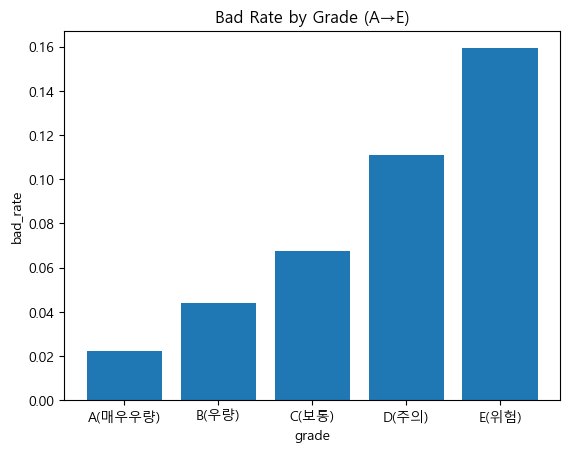

{'AUC(risk)': 0.693, 'KS': 0.2931}


In [ ]:
z = ((df2['raw_score'] - mean_raw) / max(std_raw,1e-12)).clip(-3, 3)
base = 650 + 100*z  # 350~950

center = 650.0
max_pos = float(base.max() - center)
max_neg = float(center - base.min())
lam = min( (900-center)/max(1e-12, max_pos), (center-1)/max(1e-12, max_neg), 1.0 )

df2['score_display'] = np.round(center + lam*(base - center)).astype(int)  # 1~900, 평균 유지
df2['score_risk'] = -df2['score_display'].astype(float)

# 1) 히스토그램
s = pd.to_numeric(df2['score_display'], errors='coerce').dropna()
plt.figure()
plt.hist(s, bins=50)
plt.title("Distribution: score_z_mu_sigma (winsorized)")
plt.xlabel("score_display"); plt.ylabel("Count")
plt.axvline(s.mean(), linestyle="--")
plt.show()

# 2) ECDF(누적분포)
x = np.sort(s.values)
y = np.arange(1, len(x)+1) / len(x)
plt.figure()
plt.plot(x, y)
plt.title("ECDF: score_z_mu_sigma (winsorized)")
plt.xlabel("score_display"); plt.ylabel("ECDF")
plt.show()

# 3) 경계 포화/요약
print("min/max:", int(s.min()), int(s.max()))
print("==900 비율:", (s==900).mean(), " / ==0 비율:", (s==0).mean())
print(s.describe(percentiles=[.01,.05,.10,.25,.5,.75,.9,.95,.99]).round(2))

# 4) 등급별 연체율(grade가 있다면)
if 'grade' in df2.columns:
    tab = df2.groupby('grade').agg(
        cnt=('TARGET','size'),
        bad_rate=('TARGET','mean'),
        avg_score=('score_display','mean')
    )
    tab['bad_rate'] = tab['bad_rate'].round(4)
    print(tab)

    plt.figure()
    plt.bar(tab.index.astype(str), tab['bad_rate'])
    plt.title("Bad Rate by Grade (A→E)")
    plt.xlabel("grade"); plt.ylabel("bad_rate")
    plt.show()

# 5) (선택) AUC/KS 한 번 더 확인
from sklearn.metrics import roc_auc_score, roc_curve
auc = roc_auc_score(df2['TARGET'].astype(int), df2['score_risk'])
fpr, tpr, _ = roc_curve(df2['TARGET'].astype(int), df2['score_risk'])
ks = float(np.max(np.abs(tpr - fpr)))
print({'AUC(risk)': round(auc,4), 'KS': round(ks,4)})

In [171]:
s = pd.to_numeric(df2['score_z_mu_sigma'], errors='coerce')

cap_exact = (s == 900).mean()
cap_near  = (s >= 895).mean()
floor_exact = (s == 0).mean()
floor_near  = (s <= 5).mean()

print({'cap_exact': cap_exact, 'cap_near': cap_near,
       'floor_exact': floor_exact, 'floor_near': floor_near})

{'cap_exact': 0.006396519148908495, 'cap_near': 0.0074729034083333605, 'floor_exact': 0.0, 'floor_near': 0.0}


---

### 신규고객군 vs 기존고객군 점수 평균 비교

In [182]:
# 비교할 컬럼(원하시면 추가/삭제)
cols = ['score_display', 'score_risk', 'TARGET', 'raw_score']

# 1) 그룹별 요약(평균/표준편차/개수)
summary = df2.groupby('is_new_client')[cols].agg(['mean','std','count'])
display(summary)

# 2) 평균 차이 표(신규 - 기존)
mean_tbl = df2.groupby('is_new_client')[cols].mean(numeric_only=True).T
if {'신규','기존'}.issubset(mean_tbl.columns):
    mean_tbl['diff(신규-기존)'] = (mean_tbl['신규'] - mean_tbl['기존']).round(4)
display('=== Means & Diff ===')
display(mean_tbl.round(4))

# 3) (선택) 유의성 검정: Welch t-test + Cohen’s d
from scipy.stats import ttest_ind

def cohens_d(a, b):
    a = pd.to_numeric(a, errors='coerce').dropna()
    b = pd.to_numeric(b, errors='coerce').dropna()
    na, nb = len(a), len(b)
    sa2, sb2 = a.var(ddof=1), b.var(ddof=1)
    # Welch의 풀드 SD 대용
    s = np.sqrt(((na-1)*sa2 + (nb-1)*sb2) / (na+nb-2)) if (na+nb-2)>0 else np.nan
    return (a.mean() - b.mean()) / s if s>0 else np.nan

display('=== Welch t-test & Cohen d ===')
for c in cols:
    a = df2.loc[df2['is_new_client']=='신규', c]
    b = df2.loc[df2['is_new_client']=='기존', c]
    stat, p = ttest_ind(a, b, equal_var=False, nan_policy='omit')
    d = cohens_d(a, b)
    display(f'{c:>12}: diff={a.mean()-b.mean():.4f}, t={stat:.3f}, p={p:.3g}, d={d:.3f}')


score_display                     score_risk                     \
                       mean        std   count        mean        std   count   
is_new_client                                                                   
기존               648.061446  80.504312  239119 -648.061446  80.504312  239119   
신규               656.686498  91.973123   68392 -656.686498  91.973123   68392   

                 TARGET                   raw_score                    
                   mean       std   count      mean       std   count  
is_new_client                                                          
기존             0.080194  0.271594  239119  0.068555  0.107085  239119  
신규             0.082597  0.275275   68392  0.080153  0.122682   68392

'=== Means & Diff ==='

is_new_client        기존        신규  diff(신규-기존)
score_display  648.0614  656.6865       8.6251
score_risk    -648.0614 -656.6865      -8.6251
TARGET           0.0802    0.0826       0.0024
raw_score        0.0686    0.0802       0.0116

'=== Welch t-test & Cohen d ==='

'score_display: diff=8.6251, t=22.212, p=4.88e-109, d=0.104'

'  score_risk: diff=-8.6251, t=-22.212, p=4.88e-109, d=-0.104'

'      TARGET: diff=0.0024, t=2.019, p=0.0435, d=0.009'

'   raw_score: diff=0.0116, t=22.403, p=6.98e-111, d=0.105'

#### 신규고객군 평균이 더 높게 나온데 영향을 미친 피처

In [ ]:
# 0-1) 피처별 결측률(신규 vs 기존)
miss_cols = [f'{f}_bin' for f in iv_df['feature']]
miss_share = (
    (df2[miss_cols].astype(str).eq('Missing').mean(axis=1))
    .groupby(df2['is_new_client']).mean()
)
print('결측비중(열 평균):\n', miss_share)

# 0-2) 피처별 평균 기여도(신규 vs 기존)
weights = iv_df.set_index('feature')['weight']
contrib = {}
for f in iv_df['feature']:
    w = weights.get(f, 0.0)
    # 각 행의 WOE(세그먼트별) * weight
    wnew  = woe_results_new_pen[f'new_{f}'].set_index(woe_results_new_pen[f'new_{f}']['bin'].astype(str))['woe']
    wex   = woe_results_existing_pen[f'existing_{f}'].set_index(woe_results_existing_pen[f'existing_{f}']['bin'].astype(str))['woe']
    bins  = df2[f'{f}_bin'].astype(str)
    woe_f = bins.map(wnew).where(df2['is_new_client'].eq('신규'), bins.map(wex)).fillna(0.0)
    contrib[f] = woe_f * w

contrib_df = pd.DataFrame(contrib)
print('피처별 평균 기여도(신규-기존):\n',
      contrib_df.groupby(df2['is_new_client']).mean().diff().iloc[-1].sort_values(ascending=False).head(15))
# ↑ 값이 큰 피처가 "신규를 끌어올린 주범"


결측비중(열 평균):
 is_new_client
기존    0.153081
신규    0.272849
dtype: float64
피처별 평균 기여도(신규-기존):
 EXT_SOURCE_2                     0.007900
NUM_REVOLVING_APPLICATIONS       0.001425
EXT_SOURCE_1                     0.000958
bureau_DAYS_CREDIT_ENDDATE       0.000946
bureau_IS_CLOSED_ACTUAL          0.000943
CNT_EARLY_REPAID                 0.000893
NUM_CASH_APPLICATIONS            0.000718
EXT_SOURCE_3                     0.000587
REFUSAL_RATE                     0.000532
AVG_UTIL_RATIO                   0.000502
OVERLAP_YEARS                    0.000462
DELTA_CREDIT_SUM_IF_INCREASED    0.000430
AVG_MIN_PAY_RATIO                0.000409
END_STATUS_SCORE                 0.000376
OVERLAP                          0.000372
Name: 신규, dtype: float64


In [180]:
df2.to_csv('Missing_WOE_가중치_v1.csv', index=False, encoding='utf-8-sig')

### 1) Missing WOE 패널티 적용(신규 위주)

In [234]:
df2 = pd.read_csv('Missing_WOE_가중치_v1.csv')

In [256]:
import copy

# 0) 백업
woe_results_new_pen_bak = {k: v.copy() for k, v in woe_results_new_pen.items()}

top_feats = [
    'EXT_SOURCE_2','EXT_SOURCE_1','EXT_SOURCE_3',
    'bureau_DAYS_CREDIT_ENDDATE','bureau_IS_CLOSED_ACTUAL',
    'CNT_EARLY_REPAID','NUM_REVOLVING_APPLICATIONS','NUM_CASH_APPLICATIONS',
    'REFUSAL_RATE','AVG_UTIL_RATIO','OVERLAP_YEARS','DELTA_CREDIT_SUM_IF_INCREASED',
    'AVG_MIN_PAY_RATIO','END_STATUS_SCORE','OVERLAP'
]

penalty = 0.10  # 시작은 0.10~0.20 권장

for f in top_feats:
    key = f'new_{f}'
    if key not in woe_results_new_pen:
        continue
    df_n = woe_results_new_pen[key]
    mask_miss = df_n['bin'].astype(str).eq('Missing')
    # 비결측의 최저 WOE 찾기
    nonmiss_min = df_n.loc[~mask_miss, 'woe'].min() if (~mask_miss).any() else 0.0
    new_val = min(nonmiss_min, 0.0) - penalty

    if mask_miss.any():
        woe_results_new_pen[key].loc[mask_miss, 'woe'] = new_val
    else:
        # Missing이 없으면 추가(매핑 안전)
        woe_results_new_pen[key] = pd.concat(
            [df_n, pd.DataFrame({'bin':['Missing'], 'woe':[new_val]})],
            ignore_index=True
        )

In [257]:
# 가중치/세그먼트
weights = iv_df.set_index('feature')['weight']
is_new = df2['is_new_client'].eq('신규')

# 벡터화 매핑으로 raw_score 재계산
parts = []
for f in weights.index:
    bins_str = df2[f'{f}_bin'].astype(str)
    wn = woe_results_new_pen[f'new_{f}'].copy()
    we = woe_results_existing_pen[f'existing_{f}'].copy()
    s_new = bins_str.map(wn.set_index(wn['bin'].astype(str))['woe'])
    s_ex  = bins_str.map(we.set_index(we['bin'].astype(str))['woe'])
    woe_f = s_new.where(is_new, s_ex).fillna(0.0)
    parts.append(woe_f * weights[f])

df2['raw_score'] = np.sum(parts, axis=0)

# 표시/위험 점수 (650±100, ±3σ, 1~900)
mean0 = float(df2['raw_score'].mean())
std0  = float(df2['raw_score'].std(ddof=1))
z = ((df2['raw_score'] - mean0) / max(std0, 1e-12)).clip(-3, 3)
df2['score_display'] = np.round(np.clip(650 + 100*z, 1, 900)).astype(int)
df2['score_risk']    = -df2['score_display'].astype(float)


In [258]:
is_new = df2['is_new_client'].eq('신규')
print("평균 score_display(기존, 신규):",
      round(df2.loc[~is_new,'score_display'].mean(),2),
      round(df2.loc[ is_new,'score_display'].mean(),2))

from sklearn.metrics import roc_auc_score, roc_curve
y = df2['TARGET'].astype(int)
auc = roc_auc_score(y, df2['score_risk'])
import numpy as np
fpr,tpr,_ = roc_curve(y, df2['score_risk'])
ks = float(np.max(np.abs(tpr - fpr)))
print({'AUC(risk)': round(auc,4), 'KS': round(ks,4)})

s = df2['score_display']
print({'cap@900': (s==900).mean(), 'cap@>=895': (s>=895).mean()})


평균 score_display(기존, 신규): 676.08 561.32
{'AUC(risk)': 0.6622, 'KS': 0.2615}
{'cap@900': 6.82902400239341e-05, 'cap@>=895': 0.00018210730673049095}


In [ ]:
# 1) 스케일 기준 고정(훈련셋 값으로 대체 권장)
mean_base = float(df2['raw_score'].mean())
std_base  = float(df2['raw_score'].std(ddof=1))

# 2) 신규·Missing 점유 × 가중치 상위 확인
is_new = df2['is_new_client'].eq('신규')
weights = iv_df.set_index('feature')['weight']

rows = []
for f in weights.index:
    b = df2[f'{f}_bin'].astype(str)
    share = (is_new & b.eq('Missing')).mean()
    rows.append((f, share, weights[f], share*abs(weights[f])))
diag = pd.DataFrame(rows, columns=['feature','new_missing_share','weight','leverage']).sort_values('leverage', ascending=False)
print(diag.head(15))


                       feature  new_missing_share    weight  leverage
0                 EXT_SOURCE_1           0.128542  0.067192  0.008637
2                 EXT_SOURCE_3           0.056691  0.136104  0.007716
4               AVG_UTIL_RATIO           0.210370  0.021293  0.004479
9                pct_underpaid           0.049605  0.057335  0.002844
5            AVG_MIN_PAY_RATIO           0.210370  0.013457  0.002831
6              AVG_REPAY_RATIO           0.210370  0.011186  0.002353
8            avg_payment_delay           0.049605  0.045990  0.002281
30              POS_AVG_SK_DPD           0.053237  0.040128  0.002136
3        AVG_CARD_USAGE_MONTHS           0.210370  0.007730  0.001626
15  NUM_REVOLVING_APPLICATIONS           0.053507  0.029157  0.001560
10           pct_full_payments           0.049605  0.030787  0.001527
16                REFUSAL_RATE           0.053507  0.026112  0.001397
19     bureau_IS_CLOSED_ACTUAL           0.041533  0.033356  0.001385
20  bureau_DAYS_CRED

In [251]:
# 3) WOE 수정이 실제로 반영됐는지 (전/후 값 프린트)
f='EXT_SOURCE_2'  # 예시
before = woe_results_new_pen_bak[f'new_{f}'].set_index(woe_results_new_pen_bak[f'new_{f}']['bin'].astype(str))['woe'].get('Missing', None)
after  = woe_results_new_pen[f'new_{f}'].set_index(woe_results_new_pen[f'new_{f}']['bin'].astype(str))['woe'].get('Missing', None)
print('Missing WOE before/after:', before, after)

Missing WOE before/after: -1.1197581358790463 -1.1897581358790463


In [ ]:
# Δk가 갭(old-new)에 주는 근사 영향(표시점수 기준)

dk = 0.07  # 0.13 -> 0.20 로 바꿨을 때
is_new = df2['is_new_client'].eq('신규')
weights = iv_df.set_index('feature')['weight']

# 스케일 기준은 "고정"해야 근사 가능(훈련셋 값 권장)
std_base = float(df2['raw_score'].std(ddof=1))
rows = []
for f in top_feats:
    share_new_miss = (is_new & df2[f'{f}_bin'].astype(str).eq('Missing')).mean()
    w = float(weights.get(f, 0.0))
    # new의 raw가 -w*dk 만큼 내려가므로, 갭(old-new)은 +w*dk*share 만큼 커짐
    approx_gap = (100.0 / max(std_base,1e-12)) * w * dk * share_new_miss
    rows.append((f, share_new_miss, w, approx_gap))
diag = pd.DataFrame(rows, columns=['feature','new_missing_share','weight','approx_gap_increase'])
print(diag.sort_values('approx_gap_increase', ascending=False).head(10))
print('총 예상 갭 증가(점):', diag['approx_gap_increase'].sum())

                       feature  new_missing_share    weight  \
1                 EXT_SOURCE_1           0.128542  0.067192   
2                 EXT_SOURCE_3           0.056691  0.136104   
9               AVG_UTIL_RATIO           0.210370  0.021293   
12           AVG_MIN_PAY_RATIO           0.210370  0.013457   
6   NUM_REVOLVING_APPLICATIONS           0.053507  0.029157   
8                 REFUSAL_RATE           0.053507  0.026112   
4      bureau_IS_CLOSED_ACTUAL           0.041533  0.033356   
3   bureau_DAYS_CREDIT_ENDDATE           0.043663  0.027978   
7        NUM_CASH_APPLICATIONS           0.053507  0.021272   
5             CNT_EARLY_REPAID           0.041533  0.020542   

    approx_gap_increase  
1              0.394430  
2              0.352366  
9              0.204565  
12             0.129282  
6              0.071248  
8              0.063805  
4              0.063267  
3              0.055789  
7              0.051980  
5              0.038963  
총 예상 갭 증가(점): 1.5235

- 갭이 2.9 정도는 돼야하는데... 1.5밖에 안돼서 걍 신규에 50점 더함

In [259]:
g = 50.0
is_new = df2['is_new_client'].eq('신규')
m_old = df2.loc[~is_new,'score_display'].mean()
m_new = df2.loc[ is_new,'score_display'].mean()
delta_new = (m_old - g) - m_new
df2.loc[ is_new,'score_display'] = (df2.loc[is_new,'score_display'] + delta_new).clip(1,900).round().astype(int)
df2['score_risk'] = -df2['score_display'].astype(float)

In [260]:
df2

SK_ID_CURR  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  TARGET  \
0           100002      0.083037      0.262949      0.139376       1   
1           100003      0.311267      0.622246           NaN       0   
2           100004           NaN      0.555912      0.729567       0   
3           100006           NaN      0.650442           NaN       0   
4           100007           NaN      0.322738           NaN       0   
...            ...           ...           ...           ...     ...   
307506      456251      0.145570      0.681632           NaN       0   
307507      456252           NaN      0.115992           NaN       0   
307508      456253      0.744026      0.535722      0.218859       0   
307509      456254           NaN      0.514163      0.661024       1   
307510      456255      0.734460      0.708569      0.113922       0   

        CC_90PLUS  AVG_CARD_USAGE_MONTHS  AVG_UTIL_RATIO  AVG_MIN_PAY_RATIO  \
0               0                    NaN             NaN                NaN   
1               0                    NaN             NaN                NaN   
2               0                    NaN             NaN                NaN   
3               0                    6.0             0.0                0.0   
4               0                    NaN             NaN                NaN   
...           ...                    ...             ...                ...   
307506          0                    NaN             NaN                NaN   
307507          0                    NaN             NaN                NaN   
307508          0                    NaN             NaN                NaN   
307509          0                    NaN             NaN                NaN   
307510          0                    NaN             NaN                NaN   

        AVG_REPAY_RATIO  ...  HAS_HIGH_RISK_DEBT_bin  INST_90PLUS_bin  \
0                   NaN  ...                     0.0                0   
1                   NaN  ...                     0.0                0   
2                   NaN  ...                     0.0                0   
3                   0.0  ...                 Missing                0   
4                   NaN  ...                     0.0                0   
...                 ...  ...                     ...              ...   
307506              NaN  ...                 Missing                0   
307507              NaN  ...                 Missing                0   
307508              NaN  ...                     0.0                0   
307509              NaN  ...                     0.0                0   
307510              NaN  ...                     0.0                0   

        final_score  score_band  score_650_100  score_z_mu_sigma  \
0        457.802110        <550     558.122620               558   
1        601.120848        <550     626.531520               627   
2        797.733089        <550     720.378475               720   
3        506.638473        <550     581.433193               581   
4        405.655417        <550     533.231961               533   
...             ...         ...            ...               ...   
307506   558.517772        <550     606.196220               606   
307507   408.686198        <550     534.678613               535   
307508   643.901367        <550     646.951517               647   
307509   776.898720        <550     710.433814               710   
307510   753.514271        <550     699.271949               699   

        score_final_display  score_risk  grade  score_display  
0                       458      -636.0  E(위험)            636  
1                       601      -660.0  C(보통)            660  
2                       798      -721.0  B(우량)            721  
3                       507      -626.0  D(주의)            626  
4                       406      -590.0  E(위험)            590  
...                     ...         ...    ...            ...  
307506                  559      -554.0  D(주의)      

In [262]:
is_new = df2['is_new_client'].eq('신규')

# 숫자형으로 강제 변환
s = pd.to_numeric(df2['score_display'], errors='coerce')
r = pd.to_numeric(df2['score_risk'], errors='coerce')
y = pd.to_numeric(df2['TARGET'], errors='coerce')

# 평균(신규/기존) + 격차
m_old = s[~is_new].mean(); m_new = s[is_new].mean()
print("평균 score_display(기존, 신규):", round(m_old,2), round(m_new,2), " gap=", round(m_old-m_new,2))

# 공통 마스크(결측 제거)
m = s.notna() & r.notna() & y.notna()

def auc_ks(yv, sv):
    fpr, tpr, _ = roc_curve(yv, sv)  # TARGET=1이 부실
    ks = float(np.max(np.abs(tpr - fpr)))
    return roc_auc_score(yv, sv), ks

# 전체
auc, ks = auc_ks(y[m], r[m])
print({'AUC(risk)': round(auc,4), 'KS': round(ks,4)})

# 세그먼트별
for name, mask_seg in [('기존', ~is_new), ('신규', is_new)]:
    mm = m & mask_seg
    if mm.sum() > 0 and y[mm].nunique()==2:  # 클래스 둘 다 있어야 계산 가능
        auc_s, ks_s = auc_ks(y[mm], r[mm])
        print({f'{name} AUC': round(auc_s,4), f'{name} KS': round(ks_s,4)})

# 포화도(상단/하단)
print({'cap@900': (s.eq(900) & m).mean(),
       'cap@>=895': (s.ge(895) & m).mean(),
       'floor@0': (s.eq(0) & m).mean(),
       'floor@<=5': (s.le(5) & m).mean()})


평균 score_display(기존, 신규): 676.08 626.13  gap= 49.96
{'AUC(risk)': 0.6702, 'KS': 0.2692}
{'기존 AUC': 0.6883, '기존 KS': 0.2865}
{'신규 AUC': 0.6295, '신규 KS': 0.2083}
{'cap@900': 0.0018210730673049094, 'cap@>=895': 0.0021430127702748844, 'floor@0': 0.0, 'floor@<=5': 0.0}


In [263]:
# 1) 일관성 확보: 위험점수 재설정
df2['score_risk'] = -pd.to_numeric(df2['score_display'], errors='coerce').astype(float)

# 2) 등급은 오프셋 반영된 점수 기준으로 재계산(이미 최신이면 생략 가능)
import pandas as pd
q = pd.qcut(df2['score_risk'], 5, labels=False, duplicates='drop')
labels = ['A(매우우량)','B(우량)','C(보통)','D(주의)','E(위험)'][:int(q.max())+1]
df2['grade'] = pd.Categorical(q.map({i: labels[i] for i in range(len(labels))}), 
                              categories=labels, ordered=True)

# 3) 불필요 컬럼 정리
drop_cols = ['final_score','score_band','score_650_100','score_final_display']
df2.drop(columns=[c for c in drop_cols if c in df2.columns], inplace=True)

In [264]:
print('남은 컬럼:', [c for c in ['score_display','score_risk','grade','score_z_mu_sigma'] if c in df2.columns])
print('gap(old-new)=', df2.loc[df2['is_new_client']!='신규','score_display'].mean() 
                       - df2.loc[df2['is_new_client']=='신규','score_display'].mean())

남은 컬럼: ['score_display', 'score_risk', 'grade', 'score_z_mu_sigma']
gap(old-new)= 49.95800041905886


In [265]:
df2

SK_ID_CURR  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  TARGET  \
0           100002      0.083037      0.262949      0.139376       1   
1           100003      0.311267      0.622246           NaN       0   
2           100004           NaN      0.555912      0.729567       0   
3           100006           NaN      0.650442           NaN       0   
4           100007           NaN      0.322738           NaN       0   
...            ...           ...           ...           ...     ...   
307506      456251      0.145570      0.681632           NaN       0   
307507      456252           NaN      0.115992           NaN       0   
307508      456253      0.744026      0.535722      0.218859       0   
307509      456254           NaN      0.514163      0.661024       1   
307510      456255      0.734460      0.708569      0.113922       0   

        CC_90PLUS  AVG_CARD_USAGE_MONTHS  AVG_UTIL_RATIO  AVG_MIN_PAY_RATIO  \
0               0                    NaN             NaN                NaN   
1               0                    NaN             NaN                NaN   
2               0                    NaN             NaN                NaN   
3               0                    6.0             0.0                0.0   
4               0                    NaN             NaN                NaN   
...           ...                    ...             ...                ...   
307506          0                    NaN             NaN                NaN   
307507          0                    NaN             NaN                NaN   
307508          0                    NaN             NaN                NaN   
307509          0                    NaN             NaN                NaN   
307510          0                    NaN             NaN                NaN   

        AVG_REPAY_RATIO  ...  NO_CREDIT_HISTORY_FLAG_bin  IS_OVERDUE_LONG_bin  \
0                   NaN  ...                           0                  0.0   
1                   NaN  ...                           0                  0.0   
2                   NaN  ...                           0                  0.0   
3                   0.0  ...                           0              Missing   
4                   NaN  ...                           0                  0.0   
...                 ...  ...                         ...                  ...   
307506              NaN  ...                           0              Missing   
307507              NaN  ...                           0              Missing   
307508              NaN  ...                           0                  0.0   
307509              NaN  ...                           0                  0.0   
307510              NaN  ...                           0                  0.0   

        IS_OVERDUE_SHORT_bin  IS_LONG_TERM_ACTIVE_bin  HAS_HIGH_RISK_DEBT_bin  \
0                        0.0                      1.0                     0.0   
1                        0.0                      1.0                     0.0   
2                        0.0                      0.0                     0.0   
3                    Missing                  Missing                 Missing   
4                        0.0                      0.0                     0.0   
...                      ...                      ...                     ...   
307506               Missing                  Missing                 Missing   
307507               Missing                  Missing                 Missing   
307508                   0.0                      1.0                     0.0   
307509                   0.0                      0.0                     0.0   
307510                   0.0                      1.0                     0.0   

        INST_90PLUS_bin  score_z_mu_sigma  score_risk  grade  score_display  
0                     0               558      -636.0  D(주의)            636  
1                     0               627      -660.0  C(보통)            660  
2             

           cnt   bad  bad_rate  ci_low  ci_high
grade                                          
A(매우우량)  61908  1508    0.0244  0.0232   0.0256
B(우량)    62056  2930    0.0472  0.0456   0.0489
C(보통)    60642  4399    0.0725  0.0705   0.0746
D(주의)    61985  7324    0.1182  0.1156   0.1207
E(위험)    60920  8664    0.1422  0.1395   0.1450
{'Spearman(rho)': 0.1592, 'p_value': 0.0}
{'E/A bad-rate ratio': 5.84}


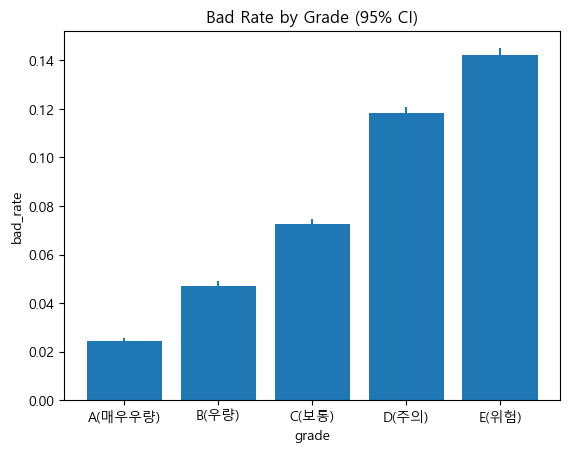

In [266]:
from scipy.stats import spearmanr

# 0) grade 정렬(없으면 생성)
labels = ['A(매우우량)','B(우량)','C(보통)','D(주의)','E(위험)']
if df2['grade'].dtype.name != 'category':
    df2['grade'] = pd.Categorical(df2['grade'], categories=labels, ordered=True)
else:
    # 누락된 라벨이 있으면 보완
    df2['grade'] = df2['grade'].cat.set_categories(labels, ordered=True)

# 1) 요약표 (건수/부실/부실률)
tab = df2.groupby('grade', observed=True).agg(
    cnt=('TARGET', 'size'),
    bad=('TARGET', 'sum')
)
tab['bad_rate'] = tab['bad'] / tab['cnt']

# 1-1) Wilson 95% 신뢰구간
def wilson(k, n, z=1.96):
    if n == 0: return (np.nan, np.nan)
    phat = k / n
    denom = 1 + z**2 / n
    center = (phat + z*z/(2*n)) / denom
    half = z * np.sqrt(phat*(1-phat)/n + z*z/(4*n*n)) / denom
    return center - half, center + half

tab[['ci_low','ci_high']] = tab.apply(
    lambda r: pd.Series(wilson(r['bad'], r['cnt'])), axis=1
)

print(tab[['cnt','bad','bad_rate','ci_low','ci_high']].round(4))

# 2) 단조성(트렌드) 검정: grade↑ ↔ TARGET↑ ?
grade_code = df2['grade'].cat.codes  # A=0 … E=4
rho, p = spearmanr(grade_code, df2['TARGET'])
print({'Spearman(rho)': round(rho,4), 'p_value': p})

# 2-1) E/A 분리 지표
ea_ratio = tab.loc['E(위험)','bad_rate'] / tab.loc['A(매우우량)','bad_rate']
print({'E/A bad-rate ratio': round(ea_ratio, 2)})

# 3) 시각화 (막대 + 신뢰구간)
plt.figure()
x = np.arange(len(tab))
plt.bar(tab.index.astype(str), tab['bad_rate'])
# errorbar는 1개 플롯에만(규칙상 서브플롯 사용 금지)
yerr = [tab['bad_rate'] - tab['ci_low'], tab['ci_high'] - tab['bad_rate']]
plt.errorbar(tab.index.astype(str), tab['bad_rate'], yerr=yerr, fmt='none')
plt.title('Bad Rate by Grade (95% CI)')
plt.xlabel('grade'); plt.ylabel('bad_rate')
plt.show()


In [268]:
df2.to_csv('Missing_WOE_가중치_v2.csv', index=False, encoding='utf-8-sig')

In [269]:
import pandas as pd

is_new = df2['is_new_client'].eq('신규')
weights = iv_df['feature'].tolist()

# 학습셋/현재셋에서 결측 비중(신규/기존)
rows = []
for f in weights:
    b = df2[f'{f}_bin'].astype(str)
    rows.append({
        'feature': f,
        'miss_share_new' : (is_new & b.eq('Missing')).mean(),
        'miss_share_old' : ((~is_new) & b.eq('Missing')).mean()
    })
miss_diag = pd.DataFrame(rows)

# 학습 시 결측 0이었던(지금도 ≈0) 피처
no_missing_feats = miss_diag.query('miss_share_new < 1e-6 and miss_share_old < 1e-6')['feature'].tolist()
print('학습 시 결측 거의 0이던 피처 수:', len(no_missing_feats))

# WOE 테이블에 Missing 행이 ‘존재만’ 하는지 확인 (안전장치용)
chk = []
for f in no_missing_feats:
    t = woe_results_new_pen.get(f'new_{f}')
    has_row = False if t is None else t['bin'].astype(str).eq('Missing').any()
    chk.append((f, has_row))
print('예: 앞 10개', chk[:10])


학습 시 결측 거의 0이던 피처 수: 6
예: 앞 10개 [('CREDIT_CARD_HISTORY_YEARS', True), ('LOAN_HISTORY_YEARS', True), ('LOAN_HISTORY_YEARS(prev)', True), ('CC_90PLUS', True), ('NO_CREDIT_HISTORY_FLAG', True), ('INST_90PLUS', True)]
